# Inport Data and libraries

In [ ]:
#!rm -rf /content/Data

In [3]:
!cp "/content/Data/s66_TBS_SegmentsNum_SegmentDelay(noSched).csv" "/content/s66_TBS_SegmentsNum_SegmentDelay(noSched).csv"

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from google.colab import files
from google.colab import drive
import os
import glob

!pip install pandas numpy scikit-learn tensorflow matplotlib 0> /dev/null 1> /dev/null 2> /dev/null
drive.mount('/content/drive',force_remount=True)
if not os.path.exists("/content/Data/"):
  print("Copying the CSV files from google drive")
  os.makedirs("/content/Data/")
  !ls "/content/drive/MyDrive/Visualization/data/csv" | xargs -I {} cp "/content/drive/MyDrive/Visualization/data/csv/"{} /content/Data/
  print("Files uploaded:")
  !ls /content/Data/
print("Reading the CSV files")
csv_files = glob.glob(f"/content/Data/*.csv")
print("\nCombining all uploaded files into a single DataFrame...")
combined_df = pd.concat([pd.read_csv(file, index_col=0) for file in csv_files], ignore_index=True)
combined_df.dropna(how='any', inplace=True)

print("\nCombined DataFrame:")
print(combined_df.head())

test_df = pd.read_csv("/content/s66_TBS_SegmentsNum_SegmentDelay(noSched).csv", index_col=0)
test_df.dropna(how='any', inplace=True)
print("\nTest DataFrame:")
print(test_df.head())
#combined_df = combined_df.drop(columns=['Unnamed: 0', 'PacketSize', 'QueueingDelay(noSched)'], axis=1)
#combined_df = combined_df.drop(columns=['PacketSize'], axis=1)

Mounted at /content/drive
Reading the CSV files

Combining all uploaded files into a single DataFrame...

Combined DataFrame:
   TBS  SegmentsNum  SegmentDelay(noSched)
0   24            1               9.505987
1   24            3               9.545088
2   24            2              11.962891
3   24            3               9.494781
4   24            1               9.520769

Test DataFrame:
   TBS  SegmentsNum  SegmentDelay(noSched)
0   24            1               9.522915
1   24            3               9.600878
2   24            2              12.004852
3   24            3               9.702682
4   24            1               9.557724


In [2]:
!pip install dowhy 0>/dev/null 1>/dev/null
!pip install econml 0>/dev/null 1>/dev/null

### Data Augumentation

In [ ]:
# from tqdm import tqdm

# df = combined_df

# # Example: df is your original dataframe
# # df must contain columns: "SegmentsNum", "TBS", "SegmentDelay(noSched)"
# # Ensure df has no missing values or handle them as needed

# # Filter rows where SegmentsNum >= 3
# high_delay_rows = df[df["SegmentsNum"] != 3]

# # List to hold augmented data
# augmented_data = []

# # Number of duplicates per row


# for idx, row in tqdm(
#     high_delay_rows.iterrows(),
#     total=high_delay_rows.shape[0],
#     desc="Augmenting Data",
#     unit="row",
# ):
#     original_delay = row["SegmentDelay(noSched)"]

#     if row["SegmentsNum"] == 1 or row["SegmentsNum"] == 2 or row["SegmentsNum"] == 4:
#         N_DUPLICATES = 1000
#     elif row["SegmentsNum"] == 5:
#         N_DUPLICATES = 1000
#     elif row["SegmentsNum"] == 6:
#         N_DUPLICATES = 1000
#     # Calculate standard deviation for the Gaussian noise
#     # If original_delay can be zero or negative, handle that case appropriately
#     # For now, we assume it's positive
#     #sigma = max(0.0001 * original_delay, 0.001)
#     sigma=0
#     # Generate noise and add to the original SegmentDelay(noSched)
#     noise = np.random.randn(N_DUPLICATES) * sigma
#     new_delays = original_delay + noise

#     # Create a DataFrame of duplicated rows
#     # Keep all columns the same except SegmentDelay(noSched), which will be varied
#     replicated_rows = pd.DataFrame(
#         {
#             "SegmentsNum": np.repeat(row["SegmentsNum"], N_DUPLICATES),
#             "TBS": np.repeat(row["TBS"], N_DUPLICATES),
#             "SegmentDelay(noSched)": new_delays,
#         }
#     )

#     # If there are other columns in df that you want to keep as is:
#     # For example, if df has columns ["SegmentsNum", "TBS", "SegmentDelay(noSched)", "SomeOtherFeat"]
#     # replicated_rows = pd.concat([
#     #     pd.DataFrame(np.repeat([row.drop("SegmentDelay(noSched)").values], N_DUPLICATES, axis=0),
#     #                  columns=row.drop("SegmentDelay(noSched)").index),
#     #     pd.DataFrame({"SegmentDelay(noSched)": new_delays})
#     # ], axis=1)

#     augmented_data.append(replicated_rows)

# # Combine all augmented rows
# augmented_df = pd.concat(augmented_data, ignore_index=True)

# # Append to original dataframe (optional)
# df_augmented = pd.concat([df, augmented_df], ignore_index=True)

# # Now df_augmented contains your original data plus the augmented samples
# print(
#     "Augmentation complete. Original size:",
#     len(df),
#     "Augmented size:",
#     len(df_augmented),
# )

# combined_df = df_augmented

In [ ]:
# Step 3: Randomly split the combined DataFrame into two (50/50 split)
data1, data2 = train_test_split(combined_df, test_size=0.3, random_state=42)


print("\nDataFrame 1 (50% of data):")
print(data1.head())

print("\nDataFrame 2 (50% of data):")
print(data2.head())

#train_file = input(f"Which file do you want to use for training?: ")
train_file = 0
# Assign training and test datasets based on user input
if train_file == '0':
    train_data, test_data = data1, data2
else:
    train_data, test_data = data2, data1


DataFrame 1 (50% of data):
        TBS  SegmentsNum  SegmentDelay(noSched)
177745   24            3               8.946180
211173   24            3               9.525061
214653   24            3               9.453058
210259   24            3               9.531736
205448   24            3               9.579659

DataFrame 2 (50% of data):
        TBS  SegmentsNum  SegmentDelay(noSched)
214378   24            3               9.353876
150762   24            3               9.432793
189530   24            3               9.735107
82258    24            3               9.473324
197915   24            3               9.612799


# 2 Classic ML

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout

import os
import re

# Directory where the images are saved
save_dir = '/content/ClassicML/'  # or some other directory path

# Pattern to match files of the form picture_<number>.png
pattern = re.compile(r'^loss_(\d+)\.png$')



In [8]:
## Start from the most simple model
## use TBS & SegmentsNum to predict SegmentDelay
## SegmentsNum treatment, TBS cofunder

# def causal_and_value_loss(y_true, y_pred, x_train):

#         return total_loss

class DelayPredictionModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape

        initial_learning_rate = 0.1
        self.lr_schedule = ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=100,
            decay_rate=0.85,
            staircase=True
        )
        optimizer=Adam(learning_rate=self.lr_schedule)
        self.model = self.build_model()
        # Compile the model with an adaptive learning rate schedule


        # Instantiate custom loss
        # self.model.compile(
        #     loss=lambda y_val, y_pred: custom_loss(y_val, y_pred, self.dissimilarity_margin),
        #     optimizer=optimizer
        # )
        self.model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    def build_model(self):
        # Define the deeper neural network model
        input_layer = Input(shape=self.input_shape, dtype='float32')

        #Third layer
        x = Dense(1024, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)

        # # Third layer
        # x = Dense(16, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)

        # # Third layer
        # x = Dense(32, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)
        # x = Dropout(0.3)(x)

        # # Third layer
        # x = Dense(64, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)
        # x = Dropout(0.3)(x)

        # Fifth layer
        x = Dense(256, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)

        # Fifth layer
        x = Dense(128, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)

        # Fifth layer
        x = Dense(64, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)

        # Output layer
        output = Dense(1, activation="linear", dtype='float32')(x)

        return tf.keras.Model(inputs=input_layer, outputs=output, name="DelayPredictionModel")

    def train(self, train_data):
        # Separate features and target for training data
        X_train = train_data.iloc[:, :-1]
        y_train = train_data.iloc[:, -1]

        # Split the training data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



        #Initialize training parameters
        batch_size = 128
        growth_factor = 1.189207
        growth_interval = 1
        epochs = 12

        # batch_size = 512
        # growth_factor = 1.414
        # growth_interval = 5
        # epochs = 20


        train_loss = []
        val_loss = []
        train_mse = []
        val_mse = []

        # Custom training loop to handle adaptive batch size
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            # Get the current step (integer)
            current_step = self.model.optimizer.iterations.numpy()

            # Call the stored lr_schedule directly
            current_lr = self.lr_schedule(current_step).numpy()
            print("Current Learning Rate:", current_lr)

            # Train the model for the current epoch
            history = self.model.fit(
                X_train, y_train,
                epochs=1,
                batch_size=batch_size,
                validation_data=(X_val, y_val),
                verbose=1
            )

            # Record metrics
            train_loss.extend(history.history['loss'])
            val_loss.extend(history.history['val_loss'])
            # Record metrics
            train_mse.extend(history.history['mse'])
            val_mse.extend(history.history['val_mse'])

            # Increase batch size at growth intervals
            if (epoch + 1) % growth_interval == 0:
                batch_size = int(batch_size * growth_factor)
                print(f"Batch size increased to {batch_size}")

        #Plot Loss over epochs
        # plt.figure(figsize=(10, 6))
        # plt.plot(train_loss, label='Training Loss')
        # plt.plot(val_loss, label='Validation Loss')
        # plt.title('Model Loss over Epochs')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend()
        # plt.grid()
        # # Save the figure to a file
        # plt.savefig('my_plot.png', dpi=300, bbox_inches='tight')

        # Plot MSE over epochs
        plt.figure(figsize=(10, 6))
        plt.plot(train_mse, label='Training MSE')
        plt.plot(val_mse, label='Validation MSE')
        plt.title('Model MSE over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Mean Absolute Error (MSE)')
        plt.legend()
        plt.grid()
        # Get all files in the directory
        files = os.listdir(save_dir)

        max_num = 0
        for f in files:
            match = pattern.match(f)
            if match:
                num = int(match.group(1))
                if num > max_num:
                    max_num = num

        # The new file will have the next number
        new_number = max_num + 1
        filename = f"loss_{new_number}.png"

        # Save the figure with the new filename
        plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')

    def predict(self, test_data):
        # Separate features and target for test data
        X_test = test_data.iloc[:, :-1]
        y_test = test_data.iloc[:, -1]

        # Evaluate on test data
        y_test_pred = self.model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print("\nFinal Test Metrics:")
        print(f"MSE: {test_mse:.4f}")
        print(f"MAE: {test_mae:.4f}")
        print(f"R^2 Score: {test_r2:.4f}")
        print("____________________________")

        return test_mse, test_mae, test_r2



Model Initializedd
Training...

Epoch 1/12
Current Learning Rate: 0.1
805/805 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 5.9248 - mse: 5.1334 - val_loss: 1.5730 - val_mse: 1.0421
Batch size increased to 152

Epoch 2/12
Current Learning Rate: 0.027249059
678/678 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 2.0361 - mse: 1.5294 - val_loss: 1.4226 - val_mse: 0.9832
Batch size increased to 180

Epoch 3/12
Current Learning Rate: 0.010276972
573/573 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1.4074 - mse: 0.9812 - val_loss: 0.8865 - val_mse: 0.4879
Batch size increased to 214

Epoch 4/12
Current Learning Rate: 0.0038759557
482/482 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1.2805 - mse: 0.8868 - val_loss: 0.8793 - val_mse: 0.4978
Batch size increased to 254

Epoch 5/12
Current Learning Rate: 0.0017197824
406/406 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 1.4163 - mse: 1.0374 - val_loss: 0.8713 - val_mse: 0.4983
Batch size increased to 302

Epoch 6/12
Current Learning Rate: 0.0008977372
342/342 ━━━━━

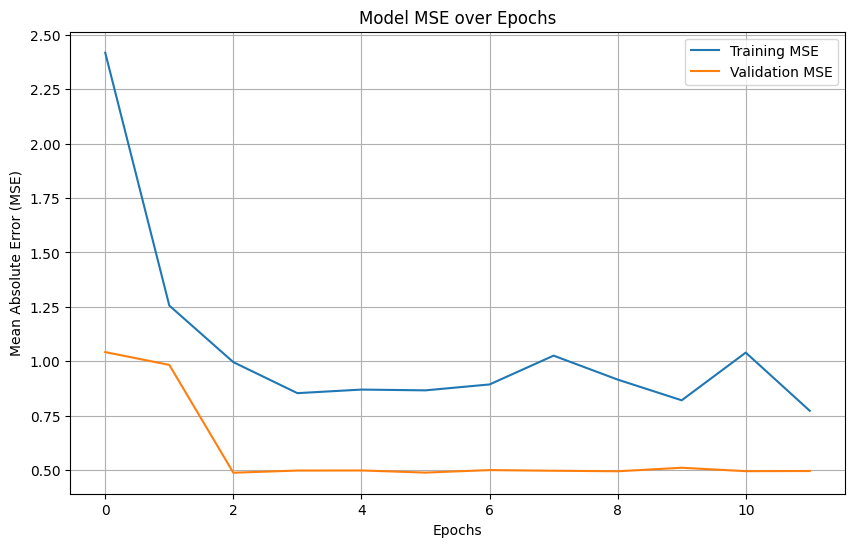

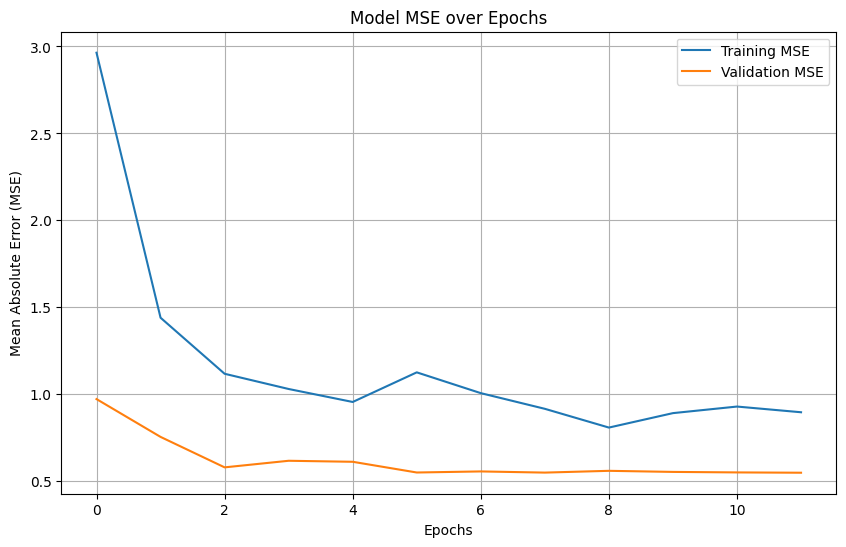

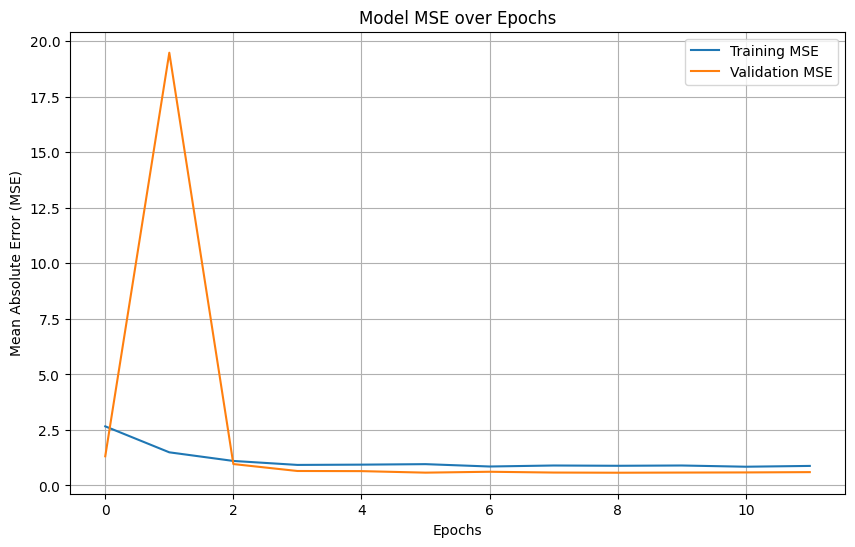

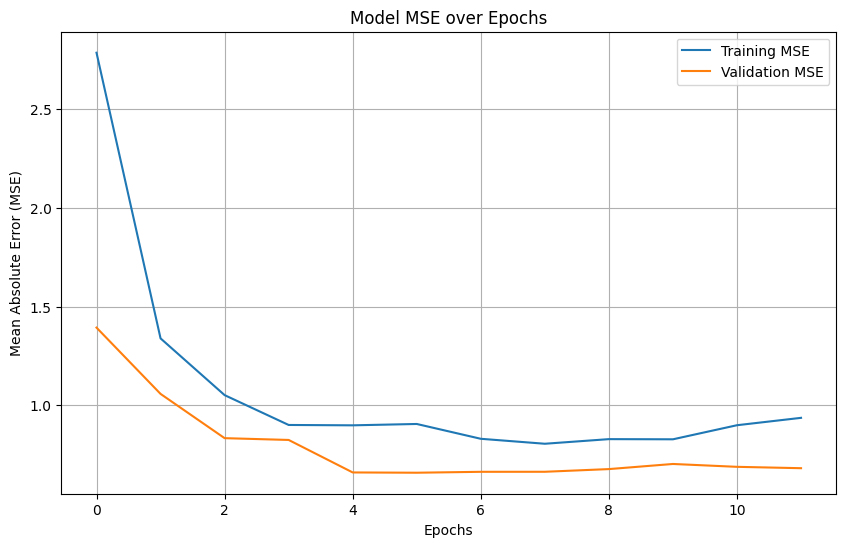

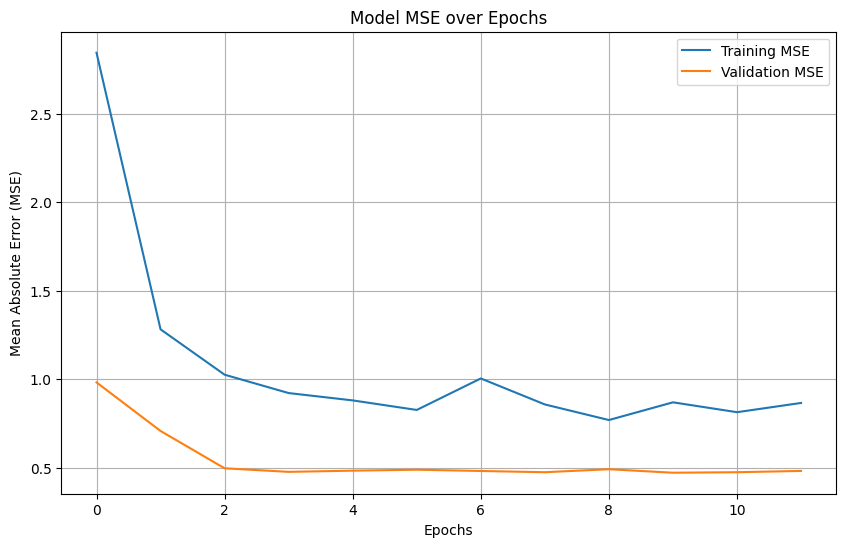

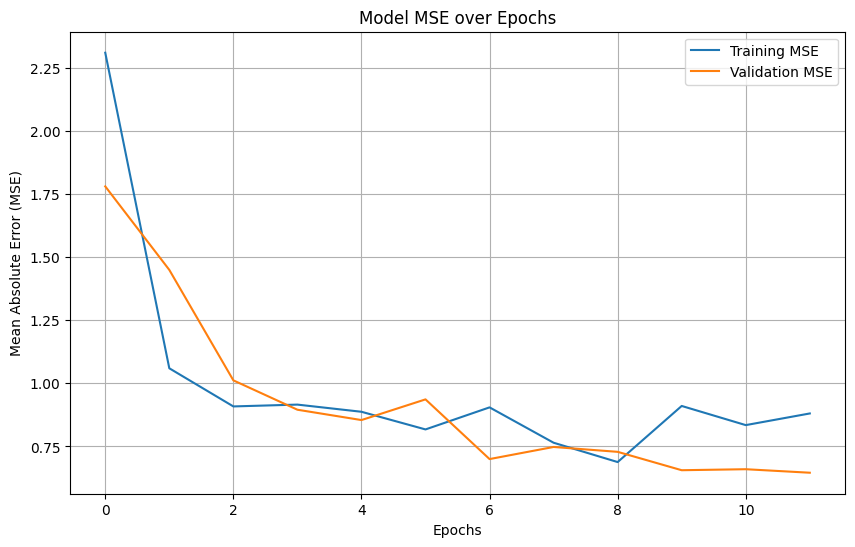

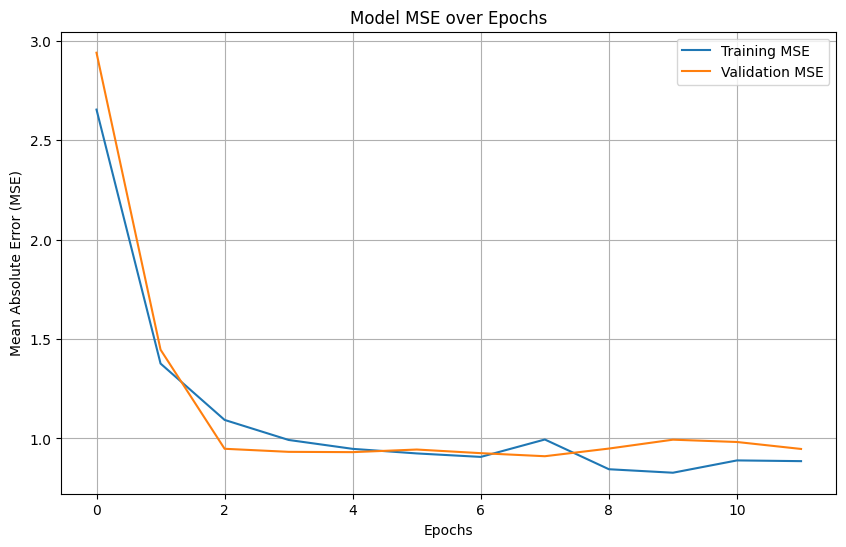

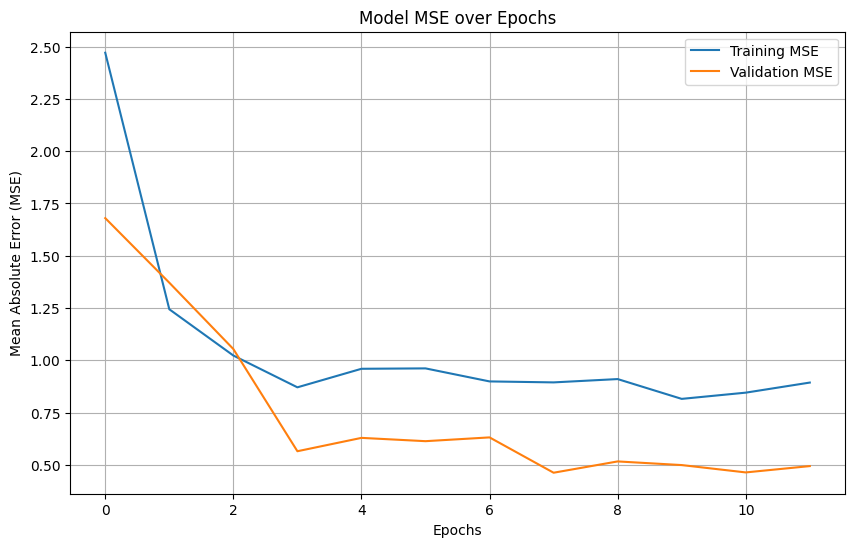

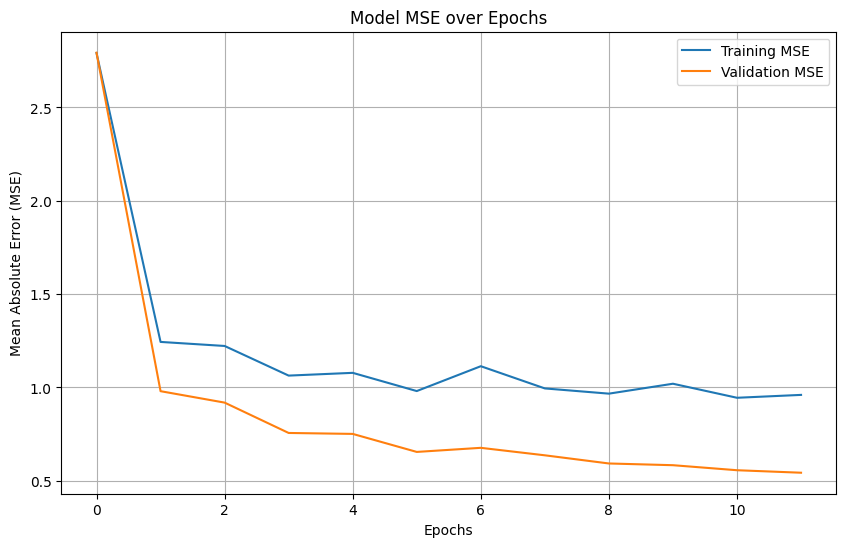

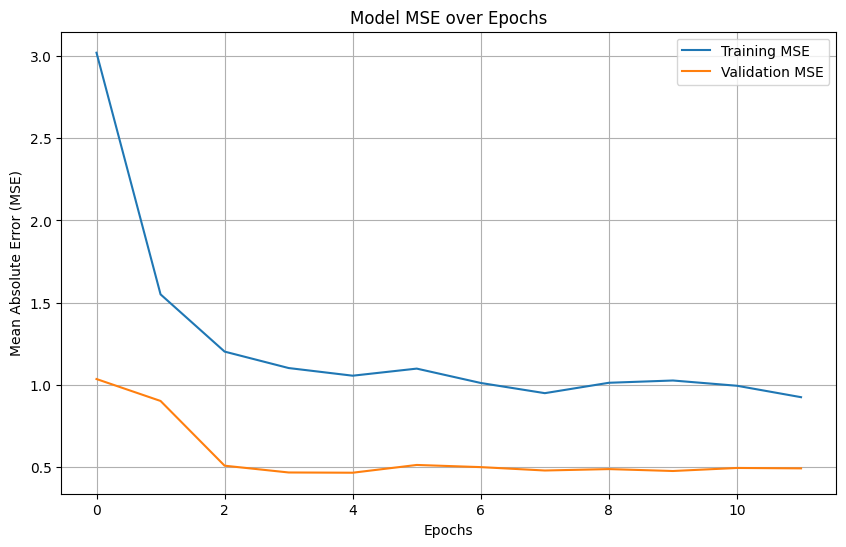

In [12]:
MSEs=[]
MAEs=[]
R2s=[]
for i in range(0,10):
  data1, data2 = train_test_split(combined_df, test_size=0.3)
  train_data, test_data = data1, data2
  DelayPredictor = DelayPredictionModel(input_shape=(train_data.shape[1]-1,))
  print("Model Initializedd")
  print("Training...")
  DelayPredictor.train(train_data)
  print("Predicting...")
  #test_mse, test_mae, test_r2 = DelayPredictor.predict(test_data)
  test_mse, test_mae, test_r2 = DelayPredictor.predict(test_df)
  MSEs.append(test_mse)
  MAEs.append(test_mae)
  R2s.append(test_r2)

MSEs=np.array(MSEs)
MAEs=np.array(MAEs)
R2s=np.array(R2s)

print(f"MSE={np.mean(MSEs)},var[MSE]={np.var(MSEs)}")
print(f"MAE={np.mean(MAEs)},var[MAE]={np.var(MAEs)}")
print(f"R2s={np.mean(R2s)},var[R2s]={np.var(R2s)}")


# 3 Test Dowhy and EconML

  Using cached scikit_learn-1.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
econml 0.15.1 requires scikit-learn<1.6,>=1.0, but you have scikit-learn 1.6.0 which is incompatible.


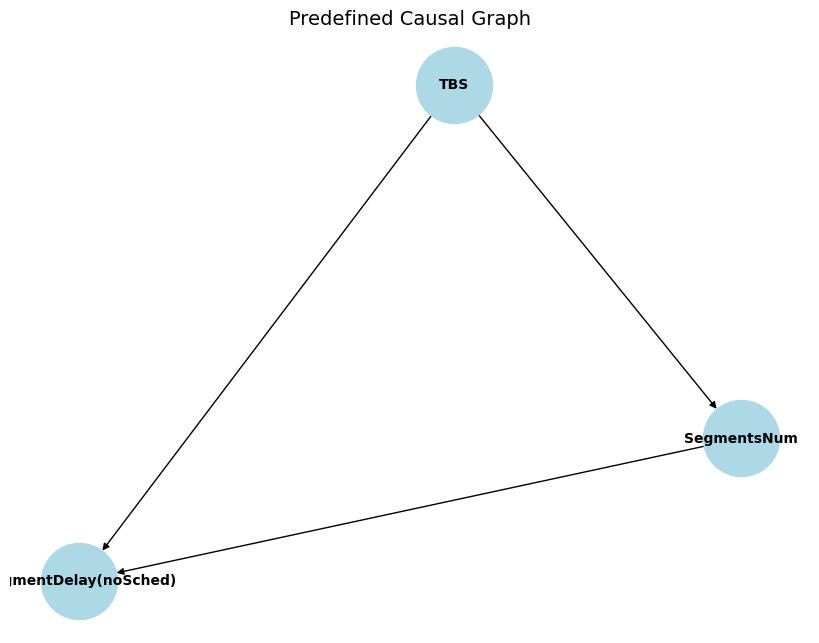

DiGraph with 3 nodes and 3 edges


In [3]:
!pip install dowhy 0>/dev/null 1>/dev/null
!pip install econml 0>/dev/null 1>/dev/null
!pip install --upgrade scikit-learn
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from dowhy import CausalModel
# Define the causal graph
causal_graph = nx.DiGraph()

# Add nodes
#causal_graph.add_nodes_from(["PacketSize", "TBS", "SegmentsNum", "SegmentDelay(noSched)"])
causal_graph.add_nodes_from(["TBS", "SegmentsNum", "SegmentDelay(noSched)"])
# Add directed edges representing causal relationships
causal_graph.add_edges_from([
    #("PacketSize", "SegmentsNum"),        # Instrument Variable → Treatment
    ("TBS", "SegmentsNum"),               # Confounder → Treatment
    ("TBS", "SegmentDelay(noSched)"),     # Confounder → Outcome
    ("SegmentsNum", "SegmentDelay(noSched)")  # Treatment → Outcome
])

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(causal_graph, seed=42)  # Layout for better visualization
nx.draw(
    causal_graph, pos, with_labels=True, arrows=True,
    node_size=3000, node_color="lightblue", font_size=10, font_weight="bold"
)
plt.title("Predefined Causal Graph", fontsize=14)
nx.write_gml(causal_graph, 'causal_graph_dag.gml')
plt.show()
print(causal_graph)

In [ ]:
# Parameters for the dataset
BETA = 10

# Step 1: Generate the dataset
# data = dowhy.datasets.linear_dataset(
#     beta=BETA,
#     num_common_causes=1,  # Adjusted for your causal graph
#     num_samples=100000,     # Smaller sample size for readability
#     #num_instruments=1,    # 1 Instrument Variable: PacketSize
#     num_effect_modifiers=0,
#     num_treatments=1,     # 1 Treatment Variable: SegmentsNum
#     treatment_is_binary=False,
#     num_discrete_common_causes=1,  # Discrete confounders: TBS
#     num_discrete_effect_modifiers=0,
#     one_hot_encode=False
# )

# Extract the dataset
df = combined_df

# Map the variables to your causal graph
df.rename(
    columns={
        "v0": "TBS",                   # Confounder
        #"v1": "PacketSize",            # Instrumental Variable
        "v2": "SegmentsNum",           # Treatment
        "y": "SegmentDelay(noSched)"   # Outcome
    },
    inplace=True
)

# Step 2: Define and visualize the causal graph
causal_graph=nx.read_gml("causal_graph_dag.gml")
model = CausalModel(
    data=df,
    treatment="SegmentsNum",
    outcome="SegmentDelay(noSched)",
    common_causes=["TBS"],
    graph=causal_graph
)


# Print the first few rows of the data
print(df.head())

model.view_model()
# from IPython.display import Image, display
# display(Image(filename="causal_model.png"))
# Print the true causal estimate
# print("True causal estimate is", data["ate"])
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from dowhy import CausalModel

In [ ]:

# Remove rows with NaN values
data_cleaned = df[:1024]

# # Ensure all columns used by DMLIV are numeric and do not contain NaNs or inf
# for col in ["TBS", "SegmentsNum", "SegmentDelay(noSched_noFrame)"]:
#     data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')
#     data_cleaned = data_cleaned.dropna(subset=[col])
#     data_cleaned = data_cleaned[np.isfinite(data_cleaned[col])]


# Redefine the causal model with the cleaned data
causal_graph=nx.read_gml("causal_graph_dag.gml")
model = CausalModel(
    data=data_cleaned,  # Use cleaned data
    treatment="SegmentsNum",
    outcome="SegmentDelay(noSched)",
    common_causes=["TBS"],
    graph=causal_graph
)


# Identify the causal effect in the defined causal model
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)



# Estimate the causal effect using the Backdoor Method
dmliv_estimate = model.estimate_effect(
    identified_estimand,
    control_value = 1,
    treatment_value = 3,
    method_name="backdoor.econml.dml.DML",
    target_units = "ate", # Target units condition for your data
    confidence_intervals=False,
    method_params={
        "init_params": {
            'discrete_treatment': True,  # SegmentsNum
            'model_y':GradientBoostingRegressor(),
            'model_t': GradientBoostingClassifier(),
            "model_final":LassoCV(fit_intercept=False),
            'featurizer':PolynomialFeatures(degree=2, include_bias=False)
            },
        "fit_params": {}
    }
)

# Print the estimated causal effect
print("Estimated Causal Effect (DML):")
print(dmliv_estimate)

for target_value in range(1,7):
  mean_value = data_cleaned.loc[data_cleaned["SegmentsNum"] == target_value, "SegmentDelay(noSched)"].mean()
  print(f"SegmentsNum'] = {target_value}: E[SegmentDelay] = {mean_value}")

# IV. Refute the obtained estimate using multiple robustness checks.
# refute_results = model.refute_estimate(identified_estimand,
#                      dmliv_estimate,
#                      method_name="random_common_cause")
# print(refute_results)

In [ ]:
print(dmliv_estimate.cate_estimates[0][0])
print(dmliv_estimate.conditional_estimates)

In [ ]:
dir(dmliv_estimate)

# 4 Causal Informed ML

### Calculate ATEs

In [13]:
import dowhy
from dowhy import CausalModel
def CalculateATE(dataframe, test=False):
  #print(f"!!!{len(dataframe)}")
  #print(dataframe.head())
  unique_values = sorted(dataframe["SegmentsNum"].unique())
  unique_values = [int(item) for item in unique_values]
  causal_graph=nx.read_gml("causal_graph_dag.gml")
  model = CausalModel(
      data=dataframe,  # Use cleaned data
      treatment="SegmentsNum",
      outcome="SegmentDelay(noSched)",
      common_causes=["TBS"],
      graph=causal_graph
  )
  # Identify the causal effect in the defined causal model
  identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
  control_val = min(unique_values)
  if_fit_estimator= True
  ATEs=[]
  for i, val in enumerate([item for item in unique_values if item != control_val]):
    #val=int(val)
    if test == True:
      print(f"SegmentsNum = {val}, True E[effect] = ", end='')
  # Estimate the causal effect using the Instrumental Variable Method
    if i != 0:
      if_fit_estimator=False
    dmliv_estimate = model.estimate_effect(
        identified_estimand,
        control_value = control_val,
        treatment_value = val,
        fit_estimator=if_fit_estimator,
        method_name="backdoor.econml.dml.DML",
        target_units = "ate", # Target units condition for your data
        confidence_intervals=False,
        method_params={
            "init_params": {
                'discrete_treatment': True,  # SegmentsNum
                'model_y':GradientBoostingRegressor(),
                'model_t': GradientBoostingClassifier(),
                "model_final":LassoCV(fit_intercept=False),
                'featurizer':PolynomialFeatures(degree=5, include_bias=True)
                },
            "fit_params": {}
        }
    )
    if test == True:
      print(dmliv_estimate.cate_estimates[0][0])
    ATEs.append(dmliv_estimate.cate_estimates[0][0])

  if test == True:
    mean_value1 = dataframe.loc[dataframe["SegmentsNum"] == control_val, "SegmentDelay(noSched)"].mean()
    for target_value in [item for item in unique_values if item != control_val]:
      mean_value2 = dataframe.loc[dataframe["SegmentsNum"] == target_value, "SegmentDelay(noSched)"].mean()
      print(f"SegmentsNum = {target_value}: E[effect] = {mean_value2} - {mean_value1}={mean_value2-mean_value1}")

  return np.array(ATEs)



#df=pd.read_csv('/content/true_batch_data.csv')
# df=data_cleaned
# data_cleaned.to_csv('data_cleaned.csv', index=False)
# print(CalculateATE(df, test=True))
# class_counts = df["SegmentDelay(noSched)"].value_counts()
# least_class_count = class_counts.min()
# print(f"least_class_count in df={least_class_count}")

In [14]:
# segmentDelay[segmentnum=1]=b=8.493280410766602;
# segmentDelay[segmentnum=2]=b+1.95

### Model Definition(Tensorflow)(Failed, DoWhy requires numpy, uncompatible with TensorFlow pipeline)

In [ ]:
# # Hyperparameter for causal loss weighting
mu = 0.1
tf.compat.v1.enable_eager_execution()  # Enable eager execution
def causal_and_value_loss(y_true, y_pred):
    # Convert tensors to numpy arrays (requires eager execution)
    x_train = tf.cast(y_true[:,0:2],tf.int32)
    y_label = tf.cast(y_true[:,2],tf.float64)

    y_true_np = y_label.numpy()
    y_pred_np = y_pred.numpy()
    x_train_np = x_train.numpy()

    # Construct dataframe for true data
    # Assuming x_train has columns [TBS, SegmentsNum], and y is SegmentDelay(noSched)
    true_batch_data = pd.DataFrame({
        "TBS": x_train_np[:, 0],
        "SegmentsNum": x_train_np[:, 1],
        "SegmentDelay(noSched)": y_true_np
    })
    predict_batch_data = pd.DataFrame({
        "TBS": x_train_np[:, 0],
        "SegmentsNum": x_train_np[:, 1],
        "SegmentDelay(noSched)": y_pred_np
    })

    true_ATEs=CalculateATE(true_batch_data)
    predict_ATEs=CalculateATE(predict_batch_data)

    # #Construct true and predicted data tensors
    # true_batch_data = {
    #     "TBS": x_train[:, 0],
    #     "SegmentsNum": x_train[:, 1],
    #     "SegmentDelay(noSched)": y_label
    # }
    # predict_batch_data = {
    #     "TBS": x_train[:, 0],
    #     "SegmentsNum": x_train[:, 1],
    #     "SegmentDelay(noSched)": y_pred
    # }

    # true_ATEs=CalculateATE_tensor(true_batch_data)
    # predict_ATEs=CalculateATE_tensor(predict_batch_data)

    # Compute losses
    # Value loss
    value_loss = tf.reduce_mean(tf.square(y_pred - y_true))
    # Causal loss
    causal_loss = tf.square(true_ATEs - predict_ATEs)  # tau_true and tau_hat are scalars

    total_loss = value_loss + mu * causal_loss
    return total_loss


In [ ]:
## Start from the most simple model
## use TBS & SegmentsNum to predict SegmentDelay
## SegmentsNum treatment, TBS cofunder

tf.compat.v1.enable_eager_execution()  # Enable eager execution
class CausalDelayPredictionModel:
    def __init__(self, input_shape):
        self.input_shape = input_shape

        initial_learning_rate = 0.1
        self.lr_schedule = ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=100,
            decay_rate=0.8,
            staircase=True
        )
        optimizer=Adam(learning_rate=self.lr_schedule)
        self.model = self.build_model()
        # Compile the model with an adaptive learning rate schedule

        self.model.compile(
          loss=lambda y_true, y_pred: causal_and_value_loss(y_true, y_pred),
          optimizer=optimizer
        )

    def build_model(self):
        # Define the deeper neural network model
        input_layer = Input(shape=self.input_shape, dtype='float32')

        # Third layer
        # x = Dense(1024, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)
        # x = Dropout(0.3)(x)

        # # Third layer
        # x = Dense(16, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)

        # # Third layer
        # x = Dense(32, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)
        # x = Dropout(0.3)(x)

        # # Third layer
        # x = Dense(64, activation="linear", kernel_initializer='he_normal',
        #           kernel_regularizer=tf.keras.regularizers.l2(1e-5))(input_layer)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)
        # x = Dropout(0.3)(x)

        # Fifth layer
        x = Dense(256, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(input_layer)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)

        # Fifth layer
        x = Dense(128, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        x = Dropout(0.3)(x)

        # Fifth layer
        x = Dense(64, activation="linear", kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        # Output layer
        output = Dense(1, activation="linear", dtype='float32')(x)

        return tf.keras.Model(inputs=input_layer, outputs=output, name="DelayPredictionModel")

    # def train(self, train_data):
    #     # Separate features and target for training data
    #     X_train = train_data.iloc[:, :-1].values
    #     y_train = train_data.iloc[:, -1].values


    #     # Split the training data into training and validation sets
    #     # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    #     datapoint_count = len(X_train)

    #     # Define a generator to yield random pairs of indices
    #     def generate_random_indices():
    #         while True:
    #             randA = np.random.randint(0, datapoint_count)
    #             yield randA

    #     random_integer_dataset = tf.data.Dataset.from_generator(
    #         generate_random_indices,
    #         output_signature=tf.TensorSpec(shape=(), dtype=tf.int32)
    #     )

    #     # Map indices to data and labels
    #     def map_indices_to_data(randA):
    #         observe = tf.convert_to_tensor(X_train[randA], dtype=tf.float32)
    #         label = tf.convert_to_tensor(y_train[randA], dtype=tf.float32)
    #         combined_label = tf.concat([observe, [label]], axis=0)
    #         return observe, combined_label

    #     random_pair_dataset = random_integer_dataset.map(map_indices_to_data)

    #     #Initialize training parameters
    #     batch_size = 128
    #     growth_factor = 1.189207
    #     growth_interval = 1
    #     epochs = 12

    #     # batch_size = 512
    #     # growth_factor = 1.414
    #     # growth_interval = 5
    #     # epochs = 20

    #     train_loss = []
    #     val_loss = []
    #     train_mse = []
    #     val_mse = []

    #     # Custom training loop to handle adaptive batch size
    #     for epoch in range(epochs):
    #         print(f"\nEpoch {epoch + 1}/{epochs}")
    #         # Get the current step (integer)
    #         current_step = self.model.optimizer.iterations.numpy()

    #         # Call the stored lr_schedule directly
    #         current_lr = self.lr_schedule(current_step).numpy()
    #         print("Current Learning Rate:", current_lr)

    #         # Train the model for the current epoch
    #         history = self.model.fit(
    #             random_pair_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE),
    #             #validation_data=(X_val, y_val),
    #             verbose=1
    #         )

    #         # Record metrics
    #         train_loss.extend(history.history['loss'])
    #         #val_loss.extend(history.history['val_loss'])

    #         # Increase batch size at growth intervals
    #         if (epoch + 1) % growth_interval == 0:
    #             batch_size = int(batch_size * growth_factor)
    #             print(f"Batch size increased to {batch_size}")

    #     #Plot Loss over epochs
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(train_loss, label='Training Loss')
    #     #plt.plot(val_loss, label='Validation Loss')
    #     plt.title('Model Loss over Epochs')
    #     plt.xlabel('Epochs')
    #     plt.ylabel('Loss')
    #     plt.legend()
    #     plt.grid()
    #     plt.show()

    def train(self, train_data):
        # Prepare training data as NumPy arrays
        X_train = train_data.iloc[:, :-1].values
        y_train = train_data.iloc[:, -1].values

        # Combine features and target for the custom loss function
        y_combined = np.hstack([X_train, y_train[:, np.newaxis]])

        # Create TensorFlow Dataset
        dataset = tf.data.Dataset.from_tensor_slices((X_train, y_combined))
        dataset = dataset.shuffle(buffer_size=1024).batch(128).prefetch(tf.data.AUTOTUNE)

        # Train the model
        self.model.fit(dataset, epochs=12, verbose=1)

    def predict(self, test_data):
        # Prepare test data
        X_test = test_data.iloc[:, :-1].values
        y_test = test_data.iloc[:, -1].values

        # Predict and evaluate
        y_pred = self.model.predict(X_test)
        mse = tf.reduce_mean(tf.square(y_test - y_pred)).numpy()
        print(f"Test MSE: {mse:.4f}")

    def predict(self, test_data):
        # Separate features and target for test data
        X_test = test_data.iloc[:, :-1]
        y_test = test_data.iloc[:, -1]

        # Evaluate on test data
        y_test_pred = self.model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        print("\nFinal Test Metrics:")
        print(f"MSE: {test_mse:.4f}")
        print(f"MAE: {test_mae:.4f}")
        print(f"R^2 Score: {test_r2:.4f}")

In [ ]:
# DelayPredictor = CausalDelayPredictionModel(input_shape=(train_data.shape[1]-1,))
# print("Model Initializedd")
# print("Training...")
# DelayPredictor.train(train_data)
# print("Predicting...")
# DelayPredictor.predict(test_data)

In [ ]:
print(tf.__version__)

2.17.1


### Model Definiction(Pytorch)

In [15]:
def causal_and_value_loss(y_true, y_pred, x_train, mu=0.01):
    # Convert PyTorch tensors to NumPy arrays
    x_train_np = x_train.detach().numpy()
    y_true_np = y_true.detach().numpy()
    y_pred_np = y_pred.detach().numpy()
    #y_pred_np = y_pred_np.astype(pd.Float64Dtype)
    # Ensure the arrays are 1-dimensional where necessary
    if x_train_np.ndim == 2 and x_train_np.shape[1] > 1:
        TBS = x_train_np[:, 0].astype(int)
        SegmentsNum = x_train_np[:, 1].astype(int)
    else:
        raise ValueError("Expected x_train_np to have at least two columns for TBS and SegmentsNum.")

    if y_true_np.ndim > 1:
        y_true_np = y_true_np.flatten()
    if y_pred_np.ndim > 1:
        y_pred_np = y_pred_np.flatten()

    # Construct DataFrames
    true_batch_data = pd.DataFrame({
        "TBS": TBS,
        "SegmentsNum": SegmentsNum,
        "SegmentDelay(noSched)": y_true_np
    })
    true_batch_data = pd.concat([true_batch_data, true_batch_data], ignore_index=True)
    #true_batch_data.to_csv('true_batch_data.csv', index=False)
    #print(  true_batch_data.head())

    predict_batch_data = pd.DataFrame({
        "TBS": TBS,
        "SegmentsNum": SegmentsNum,
        "SegmentDelay(noSched)": y_pred_np
    })
    predict_batch_data = pd.concat([predict_batch_data, predict_batch_data], ignore_index=True)
    #print(  predict_batch_data.head())

    # Calculate ATEs
    print("true_batch_data ATEs:")
    true_ATEs = np.array(CalculateATE(true_batch_data, test=False))  # Ensure it's a NumPy array
    print("predict_batch_data ATEs:")
    predict_ATEs = np.array(CalculateATE(predict_batch_data, test=False))  # Ensure it's a NumPy array

    # # Adjust predict_ATEs
    # if predict_ATEs.size > 0:  # Check if predict_ATEs is not empty
    #     # Find indices of negative elements in predict_ATEs
    #     negative_predict_indices = np.where(predict_ATEs < 0)
    #     # Assign the corresponding values from true_ATEs
    #     predict_ATEs[negative_predict_indices] = true_ATEs[negative_predict_indices]

    # Adjust true_ATEs
    if true_ATEs.size > 0:  # Check if true_ATEs is not empty
        # Find indices of negative elements in true_ATEs
        negative_true_indices = np.where(true_ATEs < 0)
        # Assign the corresponding values from predict_ATEs
        true_ATEs[negative_true_indices] = predict_ATEs[negative_true_indices]

    # Convert ATEs to PyTorch tensors
    true_ATEs_tensor = torch.tensor(true_ATEs, dtype=torch.float64)
    predict_ATEs_tensor = torch.tensor(predict_ATEs, dtype=torch.float64)

    # Compute losses
    value_loss = torch.mean((y_pred - y_true) ** 2)
    causal_loss = torch.mean((true_ATEs_tensor - predict_ATEs_tensor) ** 2)
    causal_loss = torch.nan_to_num(causal_loss, nan=0.0)
    print(f"value_loss={value_loss}")
    print(f"causal_loss={causal_loss}")
    print("_________________________")
    total_loss = value_loss + mu * causal_loss
    return total_loss

$y=SegmentDelay$

$\hat{y}=predicted\text{ } SegmentDelay$

$L_{value}=(\widehat{y} - y)^2$

$L_{causal}=\left[\widehat{ATE}(Segments, TBS, \widehat{y})  - ATE(Segments, TBS, y)\right]^2$

$L_{total} = L_{value}+ L_{causal}$

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch.nn.functional as F


class CausalDelayPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(CausalDelayPredictionModel, self).__init__()

        #Define layers with L2 regularization (weight decay)
        self.fc0 = nn.Linear(input_size, 1024)
        self.bn0 = nn.BatchNorm1d(1024)  # Batch normalization
        self.dropout0 = nn.Dropout(0.1)  # Dropout

        self.fc1 = nn.Linear(1024, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization
        self.dropout1 = nn.Dropout(0.1)  # Dropout

        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Batch normalization
        self.dropout2 = nn.Dropout(0.1)  # Dropout

        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)  # Batch normalization
        self.dropout3 = nn.Dropout(0.1)  # Dropout

        self.fc4 = nn.Linear(64, 1)

        # He Normal Initialization
        nn.init.kaiming_normal_(self.fc0.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.fc4.weight, nonlinearity='linear')  # Output layer doesn't use ReLU

        # Optional L2 regularization (applied via optimizer later)
        self.l2_regularization = 1e-5  # Set L2 regularization factor here

    def forward(self, x):
        x = F.relu(self.bn0(self.fc0(x)))  # Apply BatchNorm and ReLU
        x = self.dropout1(x)              # Apply Dropout

        x = F.relu(self.bn1(self.fc1(x)))  # Apply BatchNorm and ReLU
        x = self.dropout1(x)              # Apply Dropout

        x = F.relu(self.bn2(self.fc2(x)))  # Apply BatchNorm and ReLU
        x = self.dropout2(x)              # Apply Dropout

        x = F.relu(self.bn3(self.fc3(x)))  # Apply BatchNorm and ReLU
        x = self.dropout3(x)              # Apply Dropout

        x = self.fc4(x)                   # Output layer (no activation for regression)
        return x

In [17]:
from torch.utils.data import DataLoader, TensorDataset
# Directory where the images are saved
save_dir = '/content/CausalML/'  # or some other directory path

def train_model(
    train_data,
    input_size,
    epochs=12,
    initial_batch_size=4096,
    max_batch_size=16384,
    initial_learning_rate=0.1,
    #lr_decay=0.9,
    lr_decay=0.562341,
    batch_growth_factor=1.2,
    batch_growth_interval=1
):
    # Prepare the data
    X = train_data.iloc[:, :-1].values
    y = train_data.iloc[:, -1].values
    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float64)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float64)

    # Create Datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Initialize the model, loss function, and optimizer
    model = CausalDelayPredictionModel(input_size)
    optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

    current_batch_size = initial_batch_size
    current_learning_rate = initial_learning_rate

    epoch_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Create DataLoader for current epoch with updated batch size
        train_loader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=current_batch_size, shuffle=False)

        model.train()
        epoch_loss = 0.0

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(batch_X)
            batch_y = batch_y.view(-1, 1)  # Reshape to match output

            # Calculate loss
            loss = causal_and_value_loss(batch_y, y_pred, batch_X)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        epoch_losses.append(avg_epoch_loss)

        # Validation loop
        model.eval()
        val_loss_epoch = 0.0
        with torch.no_grad():
            for val_X, val_y in val_loader:
                val_pred = model(val_X)
                val_y = val_y.view(-1, 1)
                val_loss = causal_and_value_loss(val_y, val_pred, val_X)
                val_loss_epoch += val_loss.item()

        avg_val_loss = val_loss_epoch / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        print(f"Learning Rate: {current_learning_rate:.6f}, Batch Size: {current_batch_size}")
        print("########################################################")

        # Update learning rate dynamically
        current_learning_rate *= lr_decay
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate

        # Update batch size dynamically
        if (epoch + 1) % batch_growth_interval == 0 and current_batch_size < max_batch_size:
            current_batch_size = round(min(current_batch_size * batch_growth_factor, max_batch_size))

     # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(range(0, epochs), epoch_losses, marker='o', linestyle='-', color='b', label='Train Loss')
    plt.plot(range(0, epochs), val_losses, marker='x', linestyle='--', color='r', label='Validation Loss')
    plt.title('Training and Validation Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    # Get all files in the directory
    files = os.listdir(save_dir)

    max_num = 0
    for f in files:
        match = pattern.match(f)
        if match:
            num = int(match.group(1))
            if num > max_num:
                max_num = num

    # The new file will have the next number
    new_number = max_num + 1
    filename = f"loss_{new_number}.png"

    # Save the figure with the new filename
    plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches='tight')


    return model

# Predict function
def predict(model, test_data):
    X_test = test_data.iloc[:, :-1].values
    y_test = test_data.iloc[:, -1].values

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float64)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)

    y_pred_np = y_pred.numpy().flatten()
    y_test_np = y_test_tensor.numpy()

    # Calculate metrics
    mse = torch.mean((y_pred - y_test_tensor.view(-1, 1)) ** 2).item()
    mae = torch.mean(torch.abs(y_pred - y_test_tensor.view(-1, 1))).item()
    r2 = r2_score(y_test_np, y_pred_np)

    print("\nFinal Test Metrics:")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R² Score: {r2:.4f}")
    print("▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆")
    return mse, mae, r2


Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=92.2746048433107
causal_loss=712.4194878440709
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=84.65097338385277
causal_loss=1700.6351171270726
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=55.127585318270036
causal_loss=152.56986775814505
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=34.59972137622393
causal_loss=198.27892927672247
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=13.4118057259955
causal_loss=2.518172073405839
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.587431169708708
causal_loss=9.392781278818815
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.8827656241743265
causal_loss=543.424460848801
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.815737727551483
causal_loss=132.52050195014417
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=22.943788656728422
causal_loss=830.5131844972847
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.508252874328036
causal_loss=837.4564023696015
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.506481087780719
causal_loss=1123.684558931761
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.927845752142959
causal_loss=14.770891874299318
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.671501977673808
causal_loss=1912.3596860114537
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.8091539205161284
causal_loss=43.298217239580886
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.339084160684586
causal_loss=56.91991868557285
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.460622882096676
causal_loss=1152.3125029068106
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.383739576519298
causal_loss=123.66441167069935
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.039937722140179
causal_loss=647.5443409220721
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.230251807033424
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.938637303742977
causal_loss=348.10626017912614
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0616155464930963
causal_loss=2.989000562224483
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3585726769698723
causal_loss=446.51881235465294
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=95.33401180122246
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=481.5009778720249
causal_loss=262.01981153628884
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=494.1876387002204
causal_loss=802.4999711115397
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=578.2058608706202
causal_loss=718.8584416241818
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=478.2413883785705
causal_loss=862.3689300794907
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=491.279445002163
causal_loss=729.4856924758607
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=480.31002602208235
causal_loss=460.30365818804296
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=481.4067155922537
causal_loss=893.8086573467758
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=480.31282493419235
causal_loss=167.13185207757252
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=482.05087262003366
causal_loss=218.80508057109893
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=590.9414039747346
causal_loss=249.16152452199807
_________________________
Epoch 1/12, Train Loss: 26.7297, Val Loss: 509.2082
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6588644779974833
causal_loss=24.50731871925176
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0183697852893236
causal_loss=439.7878686348597
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.220442440607224
causal_loss=305.77188611424316
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8478454005896205
causal_loss=721.9013294575954
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1805062694866255
causal_loss=18.666002976602307
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6907446859510564
causal_loss=198.38904272223772
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.246519511339977
causal_loss=499.51495777156356
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2532766340303825
causal_loss=30.275597572152463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.9181877217878713
causal_loss=209.01205309049635
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2146844154238665
causal_loss=43.77287628971557
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4601821801812263
causal_loss=6.524967686015817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1795145499800614
causal_loss=51.436352566415685
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7845291296201201
causal_loss=8.007480049358337
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0462921906819538
causal_loss=8.074258501619354
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8205180172865962
causal_loss=3.8326818536204406
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.090278446641483
causal_loss=91.29188396335492
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1269396823964293
causal_loss=51.80866777155588
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.582077929708323
causal_loss=247.44927235761193
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1905498787385709
causal_loss=45.99405167346339
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=67.88600373931563
causal_loss=246.9776037866096
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=67.2195346507747
causal_loss=170.48601678953045
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=69.0044815079117
causal_loss=136.03890120184488
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=66.96261287931718
causal_loss=47.25524431375698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=66.91911996812728
causal_loss=162.9768676518498
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=67.20358719958092
causal_loss=433.0161394997554
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=67.16304650802347
causal_loss=85.28364566042941
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=68.1515026736745
causal_loss=532.7290552644317
_________________________
Epoch 2/12, Train Loss: 3.3995, Val Loss: 69.8322
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9361790269376699
causal_loss=78.42493197534498
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.096453144754274
causal_loss=59.09530883680766
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4752925813721105
causal_loss=3.7911868850505273
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.309169975927019
causal_loss=146.86247604388836
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.534311897468372
causal_loss=250.91442741127187
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.372863822222258
causal_loss=79.98000852751302
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4023195770569812
causal_loss=13.014773101854022
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.995951354483771
causal_loss=265.8640899873687
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1421298156077384
causal_loss=497.5607292906216
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8921656626366212
causal_loss=56.70559959017614
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8916632582510378
causal_loss=23.658266140171662
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9245364669590129
causal_loss=167.05458730794976
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.752770267243878
causal_loss=114.49804620972037
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5818364210051283
causal_loss=6.016960979335855
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.400523060317249
causal_loss=129.2282574456601
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6106502170641105
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.218190120983629
causal_loss=645.3760835104193
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.716644958737399
causal_loss=71.65231253505037
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5764409574078192
causal_loss=4.08142962609599
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9037228380340948
causal_loss=11.051993926483789
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2128833228920624
causal_loss=274.93481627167546
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4022465884311652
causal_loss=275.132843010369
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0881773643818824
causal_loss=800.8485988886242
_________________________
Epoch 3/12, Train Loss: 2.3278, Val Loss: 4.7070
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.845405017082568
causal_loss=143.76611000956783
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2341005963411926
causal_loss=277.99505667639926
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.238028642038465
causal_loss=239.3033769800716
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8501547229386258
causal_loss=146.7015734700941
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6850878510192869
causal_loss=1.1772235493775742
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.096436504479033
causal_loss=75.31474044187131
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7910110232968002
causal_loss=10.35441418530409
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.370724277976114
causal_loss=805.3654572380974
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.152612386513131
causal_loss=431.3572025839089
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5921549648550285
causal_loss=0.05488993701181948
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8374635478944638
causal_loss=36.546621998898395
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.191293169894412
causal_loss=34.20001459282941
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4299281148083856
causal_loss=178.4150851390828
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.466479355667124
causal_loss=375.10713270059796
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4066520928864943
causal_loss=28.40622838800754
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3015623077813172
causal_loss=8.462160602117487
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.38751437219757157
causal_loss=189.82650211888992
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.114079029859679
causal_loss=347.81275244254226
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.117180466495042
causal_loss=818.743930213464
_________________________
Epoch 4/12, Train Loss: 3.0861, Val Loss: 3.7462
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0051955921209603
causal_loss=89.35675721306104
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5977708369960213
causal_loss=78.38346256619438
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2266009681551817
causal_loss=635.4353684068458
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7736803258255024
causal_loss=109.09173671059264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3374892183712908
causal_loss=136.50879618705727
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0313909520559832
causal_loss=110.10138434338225
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7349938502102924
causal_loss=42.515800097806206
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3524681770170701
causal_loss=60.45468187411677
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.117456442123354
causal_loss=12.365693143900286
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.201065159682169
causal_loss=1202.7259771423544
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9804145359579879
causal_loss=176.1117956345848
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2577807575187914
causal_loss=206.90881674446962
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6389436600204127
causal_loss=31.53759456848444
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.35893307723466406
causal_loss=119.18247905501751
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8800351161562315
causal_loss=242.63821271866317
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2143974677778484
causal_loss=846.7565542418421
_________________________
Epoch 5/12, Train Loss: 3.5354, Val Loss: 3.7641
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6875873107339973
causal_loss=65.66418492153217
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8805037929596985
causal_loss=99.28776068548488
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9364172520255354
causal_loss=36.6783780444088
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8449581983628016
causal_loss=290.61483781225195
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2800736639897605
causal_loss=285.20725772219475
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8822148155947658
causal_loss=854.8103595532592
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0131046855379116
causal_loss=353.79759622072817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3755250044813698
causal_loss=5.6202989687485605
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0141826939089096
causal_loss=551.0692049024369
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.353703205975513
causal_loss=99.83040387075046
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.419128482671013
causal_loss=4.8843375750404165
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5879131354568141
causal_loss=260.6821370204666
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3294048958863045
causal_loss=443.16492161393916
_________________________
Epoch 6/12, Train Loss: 3.9269, Val Loss: 2.9439
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1039419718457144
causal_loss=66.9274202786563
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6669020978926976
causal_loss=130.06945240005155
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6285176322939369
causal_loss=17.470646102857586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.772404287578846
causal_loss=1.5173571156044252
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4577785950765898
causal_loss=449.0923828279775
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2550685655109015
causal_loss=26.254924809507262
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7287750442080341
causal_loss=207.76318737507245
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6921534576635908
causal_loss=904.4474314047782
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2947274930174877
causal_loss=32.623465382057184
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2779863414121342
causal_loss=160.95697473793325
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9708172468396761
causal_loss=403.8045102179407
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.132690309697279
causal_loss=226.67848592684174
_________________________
Epoch 7/12, Train Loss: 3.2926, Val Loss: 2.9792
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0086165056671808
causal_loss=18.61270646156221
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3814168682042025
causal_loss=36.73062197172208
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9177291608801994
causal_loss=243.9161434942886
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3301852956384679
causal_loss=447.5077530435507
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3603326341462614
causal_loss=174.43535936307595
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8072712279109747
causal_loss=253.73704995263745
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2033880247201978
causal_loss=1391.0356334420474
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.018161032732393
causal_loss=28.941334600996417
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.43085522693858347
causal_loss=228.95619965761597
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0948515451575056
causal_loss=392.0853677403395
_________________________
Epoch 8/12, Train Loss: 4.8098, Val Loss: 3.0146
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1835309866808108
causal_loss=268.1648373120321
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.183108621987618
causal_loss=27.228619831428823
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7589076151955287
causal_loss=98.83262490503074
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.031022828995548
causal_loss=174.9629450793988
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8897022175849104
causal_loss=116.71454307190805
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.057458253173259
causal_loss=1050.838297334067
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9146659260451951
causal_loss=17.740492617503236
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6373556818674139
causal_loss=219.78545573807133
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9855271984723919
causal_loss=853.2762425704732
_________________________
Epoch 9/12, Train Loss: 4.0785, Val Loss: 4.4819
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0068896804861285
causal_loss=179.10702268089398
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.643771851309767
causal_loss=188.79300913970334
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9092382785835388
causal_loss=39.92967966992367
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6988142064340699
causal_loss=39.190750313670094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0230935891536226
causal_loss=92.39769597549115
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.767917529276187
causal_loss=37.90948972942249
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.884766976477567
causal_loss=21.168064506248434
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6411615124046381
causal_loss=224.29890746011915
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9558619744619061
causal_loss=864.1866723466139
_________________________
Epoch 10/12, Train Loss: 2.1372, Val Loss: 4.5261
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3292819087671943
causal_loss=81.75867022761739
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0998708185893393
causal_loss=121.66681522845526
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.863585626158484
causal_loss=364.3368789832302
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1978329000970387
causal_loss=80.01316502223219
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2006584493486243
causal_loss=29.220898054951917
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5843478433054061
causal_loss=44.807554839929495
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8775692496341471
causal_loss=27.25245538635918
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6475422361053778
causal_loss=231.59900336531365
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9590256565356928
causal_loss=879.6108077956254
_________________________
Epoch 11/12, Train Loss: 2.2489, Val Loss: 4.6229
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.990069327223418
causal_loss=818.376167127581
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4946230768089301
causal_loss=30.361544837268376
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.907125816804208
causal_loss=469.25984179904754
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0851523092735096
causal_loss=122.00807409749167
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7652422481132816
causal_loss=82.61067577000523
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3231561420448166
causal_loss=131.0512883482365
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8824807005990367
causal_loss=20.84889846583961
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6336811117496414
causal_loss=213.91179743808243
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9366993520793038
causal_loss=839.4096398739723
_________________________
Epoch 12/12, Train Loss: 3.8503, Val Loss: 4.3982
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2356
Test MAE: 0.1751
Test R² Score: 0.6884
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=94.0605780913117
causal_loss=346.5076358882913
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=96.91226139583935
causal_loss=33.47463478465621
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=81.98832415916011
causal_loss=2228.2503542586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=68.19645823004912
causal_loss=42.07448026959657
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=62.40264651606389
causal_loss=2221.8894201885614
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=48.90881422030607
causal_loss=853.7123180404417
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=32.87105196479167
causal_loss=1500.5572023480065
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.42008061833624
causal_loss=45.24210610566679
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.2975847153664315
causal_loss=260.26112286843346
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.810649345476567
causal_loss=20.724914718455697
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.757992793352471
causal_loss=151.13381153958022
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=18.47810645951073
causal_loss=908.532327126516
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=20.341096707543272
causal_loss=316.3218712103513
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=10.693807418657167
causal_loss=98.51500283856329
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.4112770930883745
causal_loss=949.3742292907001
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.367759209798911
causal_loss=1500.6382012185245
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.79568235602657
causal_loss=1887.236938415474
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.4881577470405025
causal_loss=1330.460864987678
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.375687374517006
causal_loss=3.2785091096627625
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.552703412131056
causal_loss=1607.2931804339175
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.421111255717156
causal_loss=9.92885373028522
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.289314618417604
causal_loss=0.0
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=13.251292647253154
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3268.590422504627
causal_loss=3786.2693326918807
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3269.60371415148
causal_loss=5037.031429111335
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3395.3962746835623
causal_loss=3687.313558883778
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3285.743746352955
causal_loss=1161.2449056987227
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3262.8835668646216
causal_loss=5610.60287383297
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3252.9377601272276
causal_loss=1447.857042390492
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3269.257965715832
causal_loss=852.9342898808201
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3346.9034181036604
causal_loss=16635.859075685672
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3261.408219280305
causal_loss=2690.1718020205735
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3534.827192996081
causal_loss=3720.715475207327
_________________________
Epoch 1/12, Train Loss: 34.5759, Val Loss: 3359.3852
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.555628246373976
causal_loss=820.1064957697968
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.009137040692427
causal_loss=1.4464545202449632
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6834389611888496
causal_loss=48.0912568303602
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0101735706515824
causal_loss=49.0688427868308
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6044241789593965
causal_loss=174.17615494172622
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9808768010887856
causal_loss=191.11201238856916
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.961467756621057
causal_loss=129.11926714528602
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.565661569392224
causal_loss=107.71305973097246
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.769738513110308
causal_loss=2138.1920390399087
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8734674109026024
causal_loss=14.053690901364547
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.42002327097121
causal_loss=1291.8708130359532
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1828654784066286
causal_loss=199.03649237237116
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2631590776946822
causal_loss=9.021053705177835
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.381874933937646
causal_loss=891.1091864424541
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6254904749168004
causal_loss=28.03900495893505
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5225911885677204
causal_loss=170.85360239128363
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.4085839921490027
causal_loss=429.90226262894913
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3264638767877843
causal_loss=37.295502725253016
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2289592929508377
causal_loss=328.9599987687525
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.32905309356056
causal_loss=15.175228579757817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.537617707608636
causal_loss=54.77480461749698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.271886816366472
causal_loss=2.917249976211123
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.50767079219205
causal_loss=49.3645490238919
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.809283367502522
causal_loss=488.2605221252501
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.3010610356919
causal_loss=8.901884895025653
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.445660425745773
causal_loss=88.39024431611625
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.970532956088634
causal_loss=1364.4998467965752
_________________________
Epoch 2/12, Train Loss: 6.3140, Val Loss: 11.2370
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0139313618739414
causal_loss=70.37434178906754
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7044618704331078
causal_loss=151.08007188440425
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4413386954307776
causal_loss=283.9590133098788
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.091800256278786
causal_loss=1548.543106362678
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5065761536286832
causal_loss=636.023104606673
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9273289510223952
causal_loss=543.1102899371666
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9509450801818251
causal_loss=5.914363260185215
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.107848361580959
causal_loss=251.65869893383487
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9287426921588358
causal_loss=42.56187468252101
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8529486909559922
causal_loss=260.33442493332
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1931577279912604
causal_loss=31.957570518454858
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9631038005701518
causal_loss=529.4675250698564
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6267693095220397
causal_loss=8.027167985253609
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0638723250825792
causal_loss=188.573036233115
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6013463470427831
causal_loss=1140.7190898844901
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1368400077834173
causal_loss=1636.0695636631008
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.032823978769903
causal_loss=5.8311805260168015
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.138916757103664
causal_loss=58.68137369743882
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.164542227001291
causal_loss=29.24159537457977
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.151616757705871
causal_loss=263.17354688226084
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.213844369023233
causal_loss=8.636036321310977
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.234819057799079
causal_loss=11.471964029096124
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.379831970006057
causal_loss=1036.0869394410283
_________________________
Epoch 3/12, Train Loss: 6.2122, Val Loss: 6.3497
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2683646998944627
causal_loss=212.7591386441353
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.56401322828425
causal_loss=48.4558959391752
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.749951796656795
causal_loss=199.99812565858605
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8551477195307189
causal_loss=54.32995807832391
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0538819011986142
causal_loss=68.28678918422791
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0292578720606604
causal_loss=624.0660456451426
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7987933496417186
causal_loss=143.91500171661434
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1333325011684887
causal_loss=30.77325228884241
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4700142494109696
causal_loss=53.517014593997885
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8420858588908335
causal_loss=551.3518912969942
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.3582791120678186
causal_loss=972.0200494539085
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0461683665722143
causal_loss=280.74815442403093
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4391214833615724
causal_loss=627.1708772647012
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.17875528306102428
causal_loss=5.929695998076591
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.16731864883823622
causal_loss=41.99614899916573
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.532274303729523
causal_loss=301.94624905658264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2699860995557885
causal_loss=1.7720132580643242
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.38627688050723036
causal_loss=37.141340116539055
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6370771947848193
causal_loss=1196.9846972673574
_________________________
Epoch 4/12, Train Loss: 4.5602, Val Loss: 3.1716
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.318865401183248
causal_loss=624.5936668949123
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.532452843064526
causal_loss=219.00556144391248
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0193231598370343
causal_loss=257.93074507299156
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.031425858055042
causal_loss=19.790695982301134
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.963624129960488
causal_loss=42.059611657241454
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.939131294698592
causal_loss=897.7357680617763
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.069003637333944
causal_loss=116.50648082562246
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.348479973876319
causal_loss=1307.507980305005
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5134551951407202
causal_loss=397.60094334851755
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.392085671043251
causal_loss=319.46978420771745
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4930563902073177
causal_loss=148.47957332304287
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.20755583519609294
causal_loss=13.109614978746011
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.27454346921802997
causal_loss=45.24829704428573
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3776416000027461
causal_loss=207.17964861084155
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.20929158101124026
causal_loss=11.008511274495463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3562614693045951
causal_loss=827.1600255182444
_________________________
Epoch 5/12, Train Loss: 5.3752, Val Loss: 2.6925
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6535263703532725
causal_loss=440.93832325491303
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8744142678873493
causal_loss=65.16634161067054
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8303853771653449
causal_loss=9.01960155993026
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4590371778510884
causal_loss=425.7403255029934
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9304619084386568
causal_loss=310.74954050265194
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8757317350783012
causal_loss=34.87957657258816
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1998745226918723
causal_loss=42.72193153494575
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3937463052831467
causal_loss=66.46540312373418
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.886934381305749
causal_loss=64.44475434774901
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.20973791738854441
causal_loss=10.121730699370465
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.31656141875649574
causal_loss=209.7677909920166
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3028918175422502
causal_loss=29.701102997158372
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8456004350750099
causal_loss=799.2175205173772
_________________________
Epoch 6/12, Train Loss: 2.8562, Val Loss: 3.0407
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.195679221048753
causal_loss=337.5869233045824
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8526605742965578
causal_loss=200.48160244557053
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0918276348650113
causal_loss=295.2467084987294
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7551937183989061
causal_loss=330.9037889635042
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1392527927790055
causal_loss=217.06605699123722
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.733924939961825
causal_loss=41.41548207619648
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3951282793777557
causal_loss=20.805070712792805
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.467487167218715
causal_loss=158.8386590395063
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.20406807782580774
causal_loss=18.471751643584078
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.34888837893788477
causal_loss=113.6489718653535
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.36165448352837964
causal_loss=1.0103046161066445
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.695140342450289
causal_loss=978.17862016324
_________________________
Epoch 7/12, Train Loss: 3.3318, Val Loss: 3.4307
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0504673041656436
causal_loss=299.4239791811243
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.682709738632654
causal_loss=41.78563194058674
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4546594688509336
causal_loss=215.09868520911232
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2818830492765074
causal_loss=395.9106609343115
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2301819415428954
causal_loss=130.39565277028365
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8595722236920623
causal_loss=44.87722638506571
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.367127582027142
causal_loss=1753.1190841458254
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.18053561481017796
causal_loss=10.464956449564637
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.33351353776949133
causal_loss=141.55687618191948
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7889835130629943
causal_loss=215.17439156872658
_________________________
Epoch 8/12, Train Loss: 5.9618, Val Loss: 1.6583
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.26982701948114
causal_loss=35.760950650276996
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9787520668703462
causal_loss=104.71416839967154
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0069665855047012
causal_loss=20.260630101634348
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.368421957302003
causal_loss=969.1773943951084
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.249665509285514
causal_loss=270.17383732893126
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2844427817631123
causal_loss=716.5471879565574
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.22992299416984105
causal_loss=4.482792581260906
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.26728467159759783
causal_loss=108.55222070759787
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0514402560921594
causal_loss=716.0686394069885
_________________________
Epoch 9/12, Train Loss: 4.8874, Val Loss: 3.2799
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0396318748970037
causal_loss=40.6022687372434
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2298830287532205
causal_loss=203.11775498444
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1882893375982964
causal_loss=27.5068196673907
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.454560548130409
causal_loss=200.03029119456536
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1610537632159592
causal_loss=180.47989607571841
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9821019879784079
causal_loss=322.6014885990404
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2270891398016387
causal_loss=5.307845326020409
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2588981659318005
causal_loss=88.64561708762344
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0284957998916078
causal_loss=680.8263782656998
_________________________
Epoch 10/12, Train Loss: 2.9665, Val Loss: 3.0874
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1636062093004158
causal_loss=60.82398321192952
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.187123833303978
causal_loss=74.61351136778656
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1968198006042685
causal_loss=98.63375173467406
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.60581173593077
causal_loss=509.4826604241092
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0996531755883632
causal_loss=215.9633142634594
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.331438575247523
causal_loss=64.28171805192743
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.22602989674753787
causal_loss=3.1189181915869764
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.25594752661406506
causal_loss=79.71135270706257
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0155504954044945
causal_loss=664.2022248436612
_________________________
Epoch 11/12, Train Loss: 2.9704, Val Loss: 2.9893
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.527529182712979
causal_loss=9.117653216886094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9453662606237861
causal_loss=84.11932743919967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1116443476530735
causal_loss=221.61447942451332
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4758505588263224
causal_loss=709.7149564758997
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4151199350199626
causal_loss=468.33819030746463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3211817078156387
causal_loss=62.902463122027626
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2246652989755032
causal_loss=1.6684966495374034
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2515896411995333
causal_loss=69.91137005910142
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0011194187804515
causal_loss=639.1883493989774
_________________________
Epoch 12/12, Train Loss: 3.8925, Val Loss: 2.8617
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2542
Test MAE: 0.2034
Test R² Score: 0.6637
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=88.78046558984661
causal_loss=500.8292851348697
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=77.00588575569564
causal_loss=25.56207189603308
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=61.70961930016883
causal_loss=241.6713495048967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=33.73654721529019
causal_loss=342.74627827055093
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=15.160598212147026
causal_loss=170.7842072405974
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.759379591448587
causal_loss=185.39302421238355
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.636567153238506
causal_loss=1147.0241460914788
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=26.14498022712724
causal_loss=2075.4001108757916
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=26.738689915519604
causal_loss=234.3070234687225
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.770096366324658
causal_loss=8.778993665164418
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.672558380235193
causal_loss=411.50675844380913
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0954666176386434
causal_loss=209.18943718884955
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.305827806649334
causal_loss=2734.4703452881854
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.744005299447989
causal_loss=1924.06074132758
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.052936822685348
causal_loss=457.98760902356327
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.215311378112046
causal_loss=4.324656216387903
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.521027385097028
causal_loss=545.3338031033276
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.663916906664715
causal_loss=295.2008605914976
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.866197227923884
causal_loss=506.3233024289034
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.8449614320660745
causal_loss=2514.768807689025
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.692930822262292
causal_loss=1624.794916812698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3089759820893
causal_loss=544.9120496374338
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=127.92455812794151
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=30.29615511521073
causal_loss=6.0059263341769595
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.14339919234402
causal_loss=280.6780772712627
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=34.07399685046452
causal_loss=8456.337186011406
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.39339166756492
causal_loss=1876.210349917351
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.508361023045193
causal_loss=0.07887330336653726
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.421975805631696
causal_loss=8.190817714623329
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.68099442293862
causal_loss=1693.86462806603
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.006850738791321
causal_loss=347.5462372494967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=37.824748680663404
causal_loss=2696.0592344059683
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.38978259107112
causal_loss=12.146119871198733
_________________________
Epoch 1/12, Train Loss: 31.0176, Val Loss: 31.0511
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.077762747779987
causal_loss=361.8604034582321
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.3965421917977237
causal_loss=428.9908556487421
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3901952440289864
causal_loss=223.40641157963637
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.587238443080385
causal_loss=844.9125899760196
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0509979105451
causal_loss=2.6955724587481544
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.407414741640144
causal_loss=1021.5408965921993
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.311617627603522
causal_loss=23.84714125448923
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9856274953666704
causal_loss=58.79284616913247
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.773823436120279
causal_loss=1777.4680098835797
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.634544142418687
causal_loss=639.1070373717758
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.141018115932321
causal_loss=1020.1202116378812
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2401142891747536
causal_loss=1390.4519134839531
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.143124664388895
causal_loss=251.88656236111424
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.479515516157311
causal_loss=1882.4947794566103
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5626018559012238
causal_loss=463.1515513372489
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1640697040393089
causal_loss=310.2831039954796
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4765281981968001
causal_loss=506.6303350625791
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0083931450028434
causal_loss=2197.516753290139
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8642508802300298
causal_loss=22.888402415476907
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.144331351384038
causal_loss=43.7104577499501
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.148189459510073
causal_loss=89.11134151067091
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.917041451783302
causal_loss=622.6613997008253
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.328757138989605
causal_loss=72.68243816556756
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.864535387147757
causal_loss=2.8416332478630717
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.657206158073328
causal_loss=2035.4463561221455
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.483907134056902
causal_loss=160.40073609332538
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.52147262916374
causal_loss=26.907494273108128
_________________________
Epoch 2/12, Train Loss: 9.5250, Val Loss: 8.7004
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3466588042172785
causal_loss=200.12343284506838
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0682402220302607
causal_loss=1800.9233759191065
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.4311725715929415
causal_loss=1853.5159460989519
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4468391976404091
causal_loss=352.8557688434112
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2666596540461814
causal_loss=2415.462774646161
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.203530005876232
causal_loss=56.897501222458885
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1624579921105695
causal_loss=1736.1162094900421
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8718284038384632
causal_loss=843.9250019381825
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2731091086266486
causal_loss=403.7660242367011
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2745009141119517
causal_loss=147.31823682176835
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9819310850808814
causal_loss=195.28418838200105
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3858977142431272
causal_loss=246.42357410890443
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4871995129003945
causal_loss=312.7243568010547
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.202658707677401
causal_loss=41.438564571932766
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.26071478565195
causal_loss=2096.011262785636
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.728786626643543
causal_loss=1138.4626809316014
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.723958877221361
causal_loss=41.874312439799546
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.35499629091191
causal_loss=360.8325528632827
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9002212749203273
causal_loss=454.45147547221586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5059751597546123
causal_loss=0.3537217065862434
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.022954642129816
causal_loss=2052.8357367494086
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9200417178080773
causal_loss=140.69973932651945
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4069921241983818
causal_loss=65.61901731069476
_________________________
Epoch 3/12, Train Loss: 10.8003, Val Loss: 6.0003
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.04717754836704
causal_loss=506.015488551859
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0464419120255932
causal_loss=213.42112397853413
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6974722104393511
causal_loss=388.3050465464257
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0015053698216265
causal_loss=266.9601555491714
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.4463533119197924
causal_loss=1547.34101841092
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6860996892889664
causal_loss=1962.1361350983814
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0871171090508012
causal_loss=247.84159391720257
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7172185376255202
causal_loss=1350.086478562242
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0116207443060812
causal_loss=293.74141608224534
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.184586656730481
causal_loss=27.44384662446502
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6795274491856165
causal_loss=537.6345160799355
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1715287458032906
causal_loss=1460.5677902846603
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6996183171850099
causal_loss=101.30189152329835
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.242934906336662
causal_loss=0.9815240931584889
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.651682842256041
causal_loss=543.4304889849502
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.988153057978273
causal_loss=40.56402545049856
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9347225939413497
causal_loss=1780.9000773980663
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3383603004253404
causal_loss=144.1217453227919
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.062645302840314
causal_loss=0.6867321801210234
_________________________
Epoch 4/12, Train Loss: 8.5772, Val Loss: 6.2209
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7998899251526936
causal_loss=144.5962763902597
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.78948360474435
causal_loss=4.199676853602733
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0753384884577333
causal_loss=181.94093410839537
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9463359663592248
causal_loss=363.5348614679682
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8076669486635497
causal_loss=209.95248206634423
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.288981841327366
causal_loss=1467.8833535767194
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.429221300655893
causal_loss=1175.8648577089848
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.237720650339341
causal_loss=1134.6351355458628
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.612976898266483
causal_loss=1762.8168774200972
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.475845601437687
causal_loss=1308.3932647930953
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5765248515223347
causal_loss=140.8167379258518
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.4079022746488916
causal_loss=42.181544694038095
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8642889865225145
causal_loss=279.60222733544487
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4816342604929096
causal_loss=5.862726206141517
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.289290713993863
causal_loss=1822.4587092598463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2247349819110207
causal_loss=28.469805827619908
_________________________
Epoch 5/12, Train Loss: 8.7260, Val Loss: 6.8107
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2541514624796446
causal_loss=1099.596230624036
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7645147619223153
causal_loss=132.10071198334987
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8642084223496231
causal_loss=1190.8769190094117
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9652901064340947
causal_loss=12.255391537202728
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3176799640807237
causal_loss=1128.141667477164
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4883602704617678
causal_loss=447.55213797369004
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8922979454173582
causal_loss=167.29801606238277
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.137798845299146
causal_loss=725.0292816857265
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2116420887843091
causal_loss=148.60922811219683
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.107869434831227
causal_loss=8.63125900321481
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.4403418291035606
causal_loss=231.73729842082773
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0851316317677058
causal_loss=1598.6741825913784
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.6283632463752653
causal_loss=45.44287683167675
_________________________
Epoch 6/12, Train Loss: 7.0456, Val Loss: 8.0266
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7923695443163201
causal_loss=1419.6434627784672
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6736144794184249
causal_loss=10.190127249948988
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7910505258745082
causal_loss=884.0116284057018
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6847833118068172
causal_loss=143.14551635317818
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5580325335088485
causal_loss=849.2812872540866
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8152611209685731
causal_loss=65.22103153460247
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3025499281504882
causal_loss=27.294380586185394
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4137268062374406
causal_loss=910.9653523488939
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.062833420406765
causal_loss=15.198053908383821
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.747136742169149
causal_loss=113.93254383575363
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.508165852280021
causal_loss=1453.2401350685586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2671949024017306
causal_loss=40.967108878337314
_________________________
Epoch 7/12, Train Loss: 6.7661, Val Loss: 5.9547
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5007013487292005
causal_loss=745.0918219373895
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.337931105125061
causal_loss=64.1492681845589
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1939840426804558
causal_loss=381.12069275911506
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4670118027121435
causal_loss=327.21484815123495
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.774757244133429
causal_loss=88.04347592969211
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4883694755356047
causal_loss=25.31950894573434
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.5345163423155244
causal_loss=1429.1003932339065
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5000897595337526
causal_loss=130.76159812326523
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6099535693826659
causal_loss=1283.0154807040426
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7859273884667006
causal_loss=18.64225875144142
_________________________
Epoch 8/12, Train Loss: 5.9854, Val Loss: 6.4067
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7722794000024602
causal_loss=265.80188341840216
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9765203889834909
causal_loss=691.1969514635232
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2032885324969975
causal_loss=318.7414721432196
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7433280337074453
causal_loss=689.9783106709201
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8349279044091039
causal_loss=2.292241514004948
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.906767314218583
causal_loss=124.54089522637159
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5089089759666503
causal_loss=49.111736017774575
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2582565967241988
causal_loss=1162.5010127043786
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1546912173948165
causal_loss=104.91464434774667
_________________________
Epoch 9/12, Train Loss: 4.7271, Val Loss: 5.6957
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3124410275726999
causal_loss=763.3117574093678
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.397225887363579
causal_loss=633.7418155612037
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0630935834325461
causal_loss=0.47123894957819124
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5198506892461994
causal_loss=148.04518007511558
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3876233612109488
causal_loss=44.7849245580816
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.779943228342841
causal_loss=28.765606664396458
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3025944883234089
causal_loss=86.83162191187768
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.051969124147964
causal_loss=1076.9361897953927
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9879795261726879
causal_loss=36.79658118072274
_________________________
Epoch 10/12, Train Loss: 3.9419, Val Loss: 5.1161
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9670819759373974
causal_loss=2.366282482193602
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9195214577487238
causal_loss=321.60120255996065
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.293803880039178
causal_loss=240.40425569377308
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3598120531117766
causal_loss=623.293015792798
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7353913319723655
causal_loss=50.98307648786664
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8429148263987248
causal_loss=11.951978654175642
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1860314618417003
causal_loss=18.533131086511005
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9310176865320893
causal_loss=965.4470859529761
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9351892811897234
causal_loss=207.4922292680073
_________________________
Epoch 11/12, Train Loss: 3.2708, Val Loss: 4.9890
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2633516790258783
causal_loss=558.7487706278664
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1690737989278825
causal_loss=228.20456968305743
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0746329811358852
causal_loss=789.0590697741088
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6537179791826533
causal_loss=363.7826199440212
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2112696597836747
causal_loss=0.6703492604576152
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9171594945678281
causal_loss=177.5265333960617
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1031685639518505
causal_loss=14.387046078145229
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8582295415835935
causal_loss=929.043157762212
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8740631928670931
causal_loss=57.22853737513006
_________________________
Epoch 12/12, Train Loss: 4.7449, Val Loss: 4.2807
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2630
Test MAE: 0.1231
Test R² Score: 0.6522
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=90.4887155032482
causal_loss=24.548706066006094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=78.61310816872412
causal_loss=640.8114238167343
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=53.58840784948818
causal_loss=408.29327129779125
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=32.59652726100258
causal_loss=158.09258355420494
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=18.398715352901966
causal_loss=2096.8291544980066
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.691128818850232
causal_loss=828.4294360120427
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.531367794306439
causal_loss=156.30012946936645
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=23.018235533333193
causal_loss=34.94822764400491
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=20.607792381584023
causal_loss=231.4252446478002
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.375347861539913
causal_loss=55.538684208659966
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8362644429081785
causal_loss=11.379412313561568
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8369620097159802
causal_loss=676.1257650318967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.425511356163689
causal_loss=1165.4902666184782
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.420332156277783
causal_loss=0.18352264999226064
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.061255863713388
causal_loss=2267.072781579189
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.729800030758962
causal_loss=426.712238400869
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=10.078105354615513
causal_loss=2311.8124901859396
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.610235282416715
causal_loss=212.15309196910084
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.6968490182305347
causal_loss=20.907616829623425
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.604154658610526
causal_loss=20.901055693723695
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.391817728719352
causal_loss=500.10178068308716
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9505809912874248
causal_loss=792.8305607477499
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=129.3262355069522
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1681.6109220295498
causal_loss=724.7447385494448
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1692.6120440761765
causal_loss=755.2127413890145
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1692.2324356795789
causal_loss=1465.2846166300874
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1683.018878951996
causal_loss=397.3496397735073
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1692.0570960074078
causal_loss=1438.5962688759155
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1688.0260663082595
causal_loss=964.2806836636108
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1680.4172416035988
causal_loss=122.8349278670788
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1679.8262533688571
causal_loss=37.176264274350594
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1681.364175710201
causal_loss=22.400882542915543
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1680.752577492166
causal_loss=307.9652518346535
_________________________
Epoch 1/12, Train Loss: 28.7951, Val Loss: 1691.4276
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.5225629957607336
causal_loss=2183.3721123781174
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.266056400083392
causal_loss=5.821161508907698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4115713391433016
causal_loss=546.0188703578543
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.4646593069201344
causal_loss=524.9207772627319
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.856709822208704
causal_loss=58.71321247614333
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0870263506415134
causal_loss=5.716340028992385
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.8826085550078684
causal_loss=10.162032626006381
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.55890938352372
causal_loss=542.460958574303
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.5494978310453513
causal_loss=1159.5857836257867
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.5371714509502996
causal_loss=28.753041221699476
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8238605142718756
causal_loss=37.430203535875755
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.088421458681409
causal_loss=347.97132708210114
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.264239244143149
causal_loss=101.17013517946354
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8422410856335092
causal_loss=247.3514833274969
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6848965058305917
causal_loss=22.059728532691945
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7428397029727828
causal_loss=100.92068649249623
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8551413909858823
causal_loss=2.4552285331693193
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6103819330723164
causal_loss=1058.2787105941466
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.100053030547614
causal_loss=1.4005415194309008
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=49.297939273712615
causal_loss=8.99020269105827
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=50.555376511501734
causal_loss=2.3570503329768426
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=50.57392277522727
causal_loss=81.94107434524426
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=51.27751944588527
causal_loss=2442.638304238769
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=50.36214317553723
causal_loss=92.22748441661722
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=48.54022991473476
causal_loss=26.676340199963295
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=48.56993937028623
causal_loss=633.9248932027366
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=49.20601249086439
causal_loss=86.28689967282614
_________________________
Epoch 2/12, Train Loss: 5.7366, Val Loss: 54.0167
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6456865320479541
causal_loss=539.7724497953637
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.9090600983106882
causal_loss=93.22367851099952
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2930743544714243
causal_loss=281.23134158544366
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.252559300493192
causal_loss=45.47579996355264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0796828610204425
causal_loss=126.98535082361586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2063771543454205
causal_loss=51.00691103242417
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4174567320724665
causal_loss=34.481499002163204
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8343767164503479
causal_loss=200.08713139020853
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7988432218592237
causal_loss=212.7872136527781
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5912557827662075
causal_loss=0.06414680236905415
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.852486367386358
causal_loss=4.699089885548
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.580671998386583
causal_loss=1.8756710849413796
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4634336524043996
causal_loss=63.78364486722844
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3252436846985636
causal_loss=980.4450184891908
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1377659906674085
causal_loss=344.0524501084689
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0355224965585135
causal_loss=56.026214298578644
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.942695016217924
causal_loss=5.026123308183663
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0773061729356272
causal_loss=14.179537037553068
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1525688308160826
causal_loss=92.52536572225262
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.053454385161265
causal_loss=417.29044176901664
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.730883567382981
causal_loss=115.11843140333488
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.474838102711329
causal_loss=672.8635132587893
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.33308036215225
causal_loss=101.5852261165603
_________________________
Epoch 3/12, Train Loss: 3.2365, Val Loss: 4.2787
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7302965630273447
causal_loss=29.79217640871275
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.202546984903477
causal_loss=659.9756908191911
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.930632619405081
causal_loss=683.2225126711786
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7697854061955863
causal_loss=5.062593344392276
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8387098788428904
causal_loss=418.56074506845863
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1051390096768623
causal_loss=530.3367892739775
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7398263588771248
causal_loss=375.04792956842255
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.152327857769749
causal_loss=108.5391920084377
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.044051636314524
causal_loss=526.4016849711019
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8009649834526591
causal_loss=602.315576962841
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7283784099594315
causal_loss=16.04970097251613
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.31989720371729
causal_loss=797.2002686380264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7295939176996094
causal_loss=126.42859330934806
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.125935902726319
causal_loss=27.35356475423477
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9248536314020374
causal_loss=14.13851567393181
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3239073246877266
causal_loss=430.50256343615087
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8645381798329395
causal_loss=53.31745339638708
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7887754876695229
causal_loss=248.322301867755
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9918624220511535
causal_loss=57.7106522218929
_________________________
Epoch 4/12, Train Loss: 5.0678, Val Loss: 2.3889
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8023767658397245
causal_loss=224.48287669005552
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6246252666362808
causal_loss=20.00088707141739
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.476810768279638
causal_loss=781.8429278125991
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.441841359082746
causal_loss=40.044030126260864
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5809882519064852
causal_loss=71.91290451584419
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.47359616242783753
causal_loss=4.364538136315464
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9627982089715992
causal_loss=370.3181313417379
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8577575662328989
causal_loss=16.206996759574025
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.632037847123208
causal_loss=25.783404850116558
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.819087691022851
causal_loss=441.83581729113297
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8757219503217359
causal_loss=107.10816989589925
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9256976548191616
causal_loss=6.756590768705036
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6580127753543162
causal_loss=42.76351690413886
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5076691012450698
causal_loss=162.83907152012154
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5362631899335735
causal_loss=323.99335788259
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.977605605640749
causal_loss=83.16379830302289
_________________________
Epoch 5/12, Train Loss: 3.1442, Val Loss: 2.1601
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0601507942670787
causal_loss=426.2637572988949
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3361353772822522
causal_loss=47.62503489519146
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8394211807704988
causal_loss=568.055253923513
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3101298906456529
causal_loss=11.858782620715598
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9116708229740453
causal_loss=258.8091291315799
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1991527499491477
causal_loss=230.0069565498958
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1204754524989482
causal_loss=94.80144365900107
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3799905462043354
causal_loss=148.60428307128728
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9917636404246482
causal_loss=442.2245143913632
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7831407495788411
causal_loss=20.959052838479362
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2451748572188792
causal_loss=130.94153388296579
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6437750963358081
causal_loss=183.62907219253424
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7594374184047707
causal_loss=14.571132550153493
_________________________
Epoch 6/12, Train Loss: 3.7146, Val Loss: 1.7331
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7803257540694821
causal_loss=54.69459061017043
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5104442931868385
causal_loss=412.3955284171361
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.599253160430945
causal_loss=575.4985194400375
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.206066589879449
causal_loss=255.79473880276112
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7814514635730802
causal_loss=105.38668665080115
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1272720714420952
causal_loss=297.8748426226355
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3227644021256606
causal_loss=331.3098319597713
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2016815524385764
causal_loss=38.1488538510792
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.995159915023492
causal_loss=60.07602638792196
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9794949757313043
causal_loss=66.7327816715768
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5938947733007551
causal_loss=112.86346151916034
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4341088521701679
causal_loss=2.6208729340048422
_________________________
Epoch 7/12, Train Loss: 3.7800, Val Loss: 1.3564
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0461841028999361
causal_loss=367.0620338567031
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.531336407153422
causal_loss=416.6272223430291
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9684711957283232
causal_loss=273.1474738192536
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8531301835683717
causal_loss=33.609397492959154
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8364404801194815
causal_loss=0.06587052789992502
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9542829474914658
causal_loss=368.7559875014355
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.46532816808797123
causal_loss=4.02011181075444
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9235389259172834
causal_loss=61.07999853865561
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8992114760785863
causal_loss=72.87627532905448
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6703392967495574
causal_loss=40.2279590411129
_________________________
Epoch 8/12, Train Loss: 3.1840, Val Loss: 1.4116
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.016704599635326
causal_loss=116.917959306406
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3809486539088045
causal_loss=33.91081202430266
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9743771042163529
causal_loss=23.614635867118164
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3622048281901549
causal_loss=278.28850852164624
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8070902665960262
causal_loss=456.9206868788711
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6249112012524702
causal_loss=26.60009170105377
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8381245200260874
causal_loss=45.34572564249978
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9157997914917811
causal_loss=106.26284186849402
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7503950930230413
causal_loss=385.6294665377054
_________________________
Epoch 9/12, Train Loss: 2.7548, Val Loss: 2.6256
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2986658081066835
causal_loss=208.32325218509897
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3435841692100028
causal_loss=47.87996850277368
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8275828459480774
causal_loss=189.9123971677622
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9941195074270823
causal_loss=29.547536937533316
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.410001936525926
causal_loss=20.850886708902184
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7370859991749927
causal_loss=23.940328968092228
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7694360151842904
causal_loss=27.556325144020903
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8778371323904118
causal_loss=130.04600115553362
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7458730196443738
causal_loss=1.677368119792126
_________________________
Epoch 10/12, Train Loss: 1.9693, Val Loss: 1.3286
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0009788757519487
causal_loss=58.99126401688103
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1397416164958276
causal_loss=50.52933361600089
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.296350938894079
causal_loss=151.53273350229486
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9879854900753005
causal_loss=136.57549713348698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2330931327105819
causal_loss=419.5564774690617
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9282011736288793
causal_loss=60.10951140448395
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8000531527507698
causal_loss=66.17077065408685
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9004829693901871
causal_loss=123.46632905481769
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7494144987658246
causal_loss=356.2929295864124
_________________________
Epoch 11/12, Train Loss: 2.5599, Val Loss: 2.6364
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9784973458156432
causal_loss=57.858601363547145
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.089477286210375
causal_loss=228.35366728670695
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1035464765504857
causal_loss=64.00295438221906
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9734624443851967
causal_loss=89.65088065468504
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.080637374749373
causal_loss=98.61348093329178
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5859907101970754
causal_loss=72.45779497213971
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8089889284902521
causal_loss=42.69099776305623
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9072362258396419
causal_loss=127.70080021050266
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7510788187693482
causal_loss=18.062882105513168
_________________________
Epoch 12/12, Train Loss: 2.1535, Val Loss: 1.4506
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2315
Test MAE: 0.1917
Test R² Score: 0.6938
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=89.87452003829702
causal_loss=40.41232356375588
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=71.8711196139405
causal_loss=2432.9716883393617
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=46.912732798842285
causal_loss=621.9911476122944
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=22.10897927630128
causal_loss=1942.7285441679373
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.936251388935689
causal_loss=2110.2630861205894
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.258734623720962
causal_loss=859.5012218507719
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=20.111600095307157
causal_loss=76.439875883027
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=21.177225430800434
causal_loss=149.8779778007502
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.843295643692791
causal_loss=272.77592760821386
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.2595402062438037
causal_loss=6.731753387475621
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7971059952157682
causal_loss=15.779305027475688
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.026664238754663
causal_loss=192.58768217745637
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.2151516190298794
causal_loss=19.34352210561571
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.850107605157797
causal_loss=927.2187863832712
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.665986004468678
causal_loss=218.08211007681996
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.920941571510087
causal_loss=587.967744884765
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.7145028670484113
causal_loss=50.41387672207028
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8892469020897105
causal_loss=362.9792495162355
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.3219864759810696
causal_loss=748.3278784443037
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1107914170215416
causal_loss=359.5288815568811
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.2388462945477015
causal_loss=1836.4260008647066
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.140578053249204
causal_loss=408.81840906855285
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=154.1921337976936
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=9.993222759148777
causal_loss=1406.056038080769
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=36.43496082890458
causal_loss=23.17921123985363
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.6700201439229385
causal_loss=1445.4178245965807
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2955190260564873
causal_loss=86.69669251977686
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.932800008955393
causal_loss=2589.0590579813947
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.065996565559658
causal_loss=1204.4456481104203
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.6246198391923965
causal_loss=379.3638454897264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=29.563457124521555
causal_loss=466.54115177075744
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.466650279451021
causal_loss=112.50799648638106
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6475388508809259
causal_loss=5.342362827518258
_________________________
Epoch 1/12, Train Loss: 28.5152, Val Loss: 18.0881
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7731853894067993
causal_loss=15.08957987130591
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0602150827291643
causal_loss=2227.9825761505635
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.7383037936082046
causal_loss=828.4762826484325
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.9496047241372785
causal_loss=1704.8794284228693
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.319056233900601
causal_loss=1959.0212895692991
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.104128358283905
causal_loss=23.18867671160034
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.705983229459663
causal_loss=584.3900992401353
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.58405132605552
causal_loss=51.10082178961729
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.5656563759610025
causal_loss=23.467414391402823
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.935705203080797
causal_loss=1336.0339523874072
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.025736092818506
causal_loss=710.1161656725568
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2109361639819944
causal_loss=160.5527977335726
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2888915140449044
causal_loss=27.76690085503216
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1053852316723254
causal_loss=12.41372055721186
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8592704864086139
causal_loss=5.310155647946943
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5932422652739953
causal_loss=64.88510097518825
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.89257148347219
causal_loss=134.95703525221208
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7275929454955113
causal_loss=2.9028061243802905
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.663660466006431
causal_loss=1511.2939546900288
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=30.41302388386415
causal_loss=931.4507096642176
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=31.58029266959116
causal_loss=17.12324684968588
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=30.007710633778714
causal_loss=763.0915626649286
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=29.457433604091875
causal_loss=329.6338178275124
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=30.192808207117945
causal_loss=519.3293967726094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=30.580295469538154
causal_loss=250.9688045204529
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=31.74805963540574
causal_loss=256.2468037385583
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=29.722747748544265
causal_loss=50.69811314184425
_________________________
Epoch 2/12, Train Loss: 9.0496, Val Loss: 34.3610
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3589226269955965
causal_loss=350.9184536699863
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8147699665092751
causal_loss=64.80916990367803
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.638393313500674
causal_loss=49.91490139129984
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9275953295130233
causal_loss=141.88776056269342
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.399760198205361
causal_loss=11.187553293583628
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7404246006291442
causal_loss=77.87811834964194
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.95118716879274
causal_loss=288.0994089691982
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.397231841146591
causal_loss=71.63046480743583
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.721960546870861
causal_loss=32.86776732357449
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9446547914105503
causal_loss=334.56563100564546
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7748941550727553
causal_loss=58.74697399237606
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1882024376633216
causal_loss=81.10378746295129
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.166585606558965
causal_loss=1087.4842873784582
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7213773252770421
causal_loss=8.121895451677023
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6302472352752562
causal_loss=891.620281999089
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4819102608430658
causal_loss=34.113903413102975
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.468409999850748
causal_loss=1262.5529579021809
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.823969035265
causal_loss=808.1462376257688
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.98958616164478
causal_loss=110.32988883837159
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.929365050689072
causal_loss=835.1415261157488
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.208344775748233
causal_loss=361.99650712354327
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.30142247092917
causal_loss=458.41420778274124
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.064055018453271
causal_loss=12.952490574039365
_________________________
Epoch 3/12, Train Loss: 3.7942, Val Loss: 10.3258
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0431906492791518
causal_loss=47.378727241678085
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4109260836274233
causal_loss=699.8753890796789
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9863082782179471
causal_loss=164.66353838960643
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7792438719749208
causal_loss=428.84824985408613
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.846397395758278
causal_loss=26.61158823016518
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0281765624548391
causal_loss=528.7091643525742
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1151643042110315
causal_loss=1404.9574923703535
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0627827658011753
causal_loss=125.7882050901016
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.361447356503412
causal_loss=875.2987150142403
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0085817461570867
causal_loss=498.11541268063087
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5905697300570852
causal_loss=2.3958780453413486
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8235526348062796
causal_loss=868.5691151832456
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4560214057983971
causal_loss=10.468679545355224
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6835100246929569
causal_loss=1111.963327024165
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5925673372872715
causal_loss=834.7115186405713
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1261536486316823
causal_loss=934.144402588789
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2603788338122137
causal_loss=587.2145390945223
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.968379556917682
causal_loss=453.1471107916899
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0517360822101733
causal_loss=20.164648296166867
_________________________
Epoch 4/12, Train Loss: 5.7176, Val Loss: 8.1827
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8788128745914217
causal_loss=233.0665569736519
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4735521734746298
causal_loss=55.9817543472321
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0058333974365727
causal_loss=135.78583224296256
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6460668135097216
causal_loss=81.36920829749079
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2096488906969731
causal_loss=43.469499154094045
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.112074625690171
causal_loss=8.214138542258299
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6699370800110561
causal_loss=26.089306543622207
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1924739352709766
causal_loss=35.43052374871647
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5356535775973107
causal_loss=4.020611181641461
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9712364614509732
causal_loss=405.1223580295498
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7289483548666129
causal_loss=297.2849764936932
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1000081807754232
causal_loss=809.2494992393376
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.550107028862965
causal_loss=531.1273211764145
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5626914578885794
causal_loss=375.3854709440237
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7547706387719324
causal_loss=481.68249565943506
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6903756580680295
causal_loss=41.125849872077104
_________________________
Epoch 5/12, Train Loss: 2.1530, Val Loss: 5.4087
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0312057371253363
causal_loss=217.06058568051742
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2179464603537589
causal_loss=49.99855108583957
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8852935693752846
causal_loss=782.5831191114396
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8088813679537011
causal_loss=387.2192967384358
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.367793778641527
causal_loss=56.97670951664921
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9490255911281441
causal_loss=26.113126943378838
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8002411307289764
causal_loss=6.511748958734799
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.928764160710714
causal_loss=140.70991042131718
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.083609474673121
causal_loss=314.863089051126
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8727326494853814
causal_loss=635.2703279867352
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.44450669742943655
causal_loss=287.7461748428178
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0719196736480168
causal_loss=267.82489296353907
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0285379177553087
causal_loss=24.67926712708854
_________________________
Epoch 6/12, Train Loss: 3.3215, Val Loss: 3.8932
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7692659000920632
causal_loss=133.71439071541698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7397224342551003
causal_loss=222.77651219592644
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7694553162485904
causal_loss=144.21420991426533
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9429119415365229
causal_loss=397.11200914138675
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3903793748009468
causal_loss=88.84160964771445
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9545252711021829
causal_loss=56.6061334912755
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1570148437199026
causal_loss=6.618319020869986
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0007264471259947
causal_loss=251.71461276925038
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7947545743181206
causal_loss=311.5719228485394
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.35345352740646796
causal_loss=202.87818804084415
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2518937091841509
causal_loss=102.30584543827547
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6736335172267254
causal_loss=73.7519791115844
_________________________
Epoch 7/12, Train Loss: 2.7175, Val Loss: 2.4947
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2303555816205072
causal_loss=370.8624441385167
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.19178357345963
causal_loss=152.14683882710486
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4032540116308028
causal_loss=348.97868394070053
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.013278835629715
causal_loss=299.9310697863525
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1749651051678838
causal_loss=137.0684656412934
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9905587264207331
causal_loss=71.58331694425178
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.667386290118837
causal_loss=187.30447943397277
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7181890124042696
causal_loss=295.825172980765
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6675097480907588
causal_loss=229.16403433844366
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0587127462226715
causal_loss=25.697067975353498
_________________________
Epoch 8/12, Train Loss: 3.3358, Val Loss: 2.6504
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9009321226260679
causal_loss=63.31632521527322
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9567066498820488
causal_loss=14.284267574962698
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0126705045857798
causal_loss=650.604271742167
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9047904739746278
causal_loss=8.114158565451817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2219669838059588
causal_loss=117.99491277151294
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0183567917958467
causal_loss=211.80807958921784
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6790981625323618
causal_loss=306.88325010066046
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7651807548866436
causal_loss=235.68444464383438
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1453402891179643
causal_loss=6.157843516988968
_________________________
Epoch 9/12, Train Loss: 2.7794, Val Loss: 2.6923
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2204879971669573
causal_loss=345.68056501235066
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0324657776378483
causal_loss=377.12779683434206
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3029117138707786
causal_loss=21.18625686001927
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9880355875344728
causal_loss=286.9023420195982
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7275597913991236
causal_loss=63.64091102038643
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.940061493842409
causal_loss=100.6114994367947
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6745595559297393
causal_loss=294.8167420872724
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.758708814771449
causal_loss=227.85358424537554
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1433910361430997
causal_loss=5.715421912531962
_________________________
Epoch 10/12, Train Loss: 3.0272, Val Loss: 2.6202
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0709131459060013
causal_loss=572.8513639221253
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9655649122946999
causal_loss=235.68888050814493
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.031474749187949
causal_loss=28.543100820396205
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7380569495513859
causal_loss=63.79308215519374
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2818606405808304
causal_loss=179.39620020923869
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1990073420990177
causal_loss=22.85174539610215
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6712784859700416
causal_loss=288.9839244705499
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7556580797509397
causal_loss=224.0243563535192
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1433569611684464
causal_loss=5.434454352784198
_________________________
Epoch 11/12, Train Loss: 2.8864, Val Loss: 2.5849
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8811318896306226
causal_loss=80.67359952662554
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6888045659017918
causal_loss=314.0025208195008
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8952029234334067
causal_loss=48.87666657378224
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1930402572909482
causal_loss=21.5848401251573
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.559990180661749
causal_loss=109.87521556796341
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8013471164444974
causal_loss=232.44747102646411
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6732605873577813
causal_loss=291.8259512752126
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7521378164830126
causal_loss=213.92279329232983
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1386746714480929
causal_loss=4.761523713083592
_________________________
Epoch 12/12, Train Loss: 2.3490, Val Loss: 2.5564
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2284
Test MAE: 0.1545
Test R² Score: 0.6978
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=96.58875225880763
causal_loss=712.1225050477984
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=102.73912284869127
causal_loss=163.20880396006405
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=74.58626534638981
causal_loss=37.27000067191894
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=63.00118243495129
causal_loss=1.52260782371829
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=54.354671140377256
causal_loss=779.6469803899523
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=43.64334275964514
causal_loss=2331.9065926198045
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=28.44597594938445
causal_loss=2950.7946347616057
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=13.024985794143891
causal_loss=830.5088929119233
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.6553885864327
causal_loss=2492.7380640242923
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.477669094433523
causal_loss=20.398558964469437
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=15.360326071665007
causal_loss=878.522369614797
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=20.046870891446734
causal_loss=471.0716259202336
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=21.29244038733066
causal_loss=1282.3041471562362
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=15.552172761687299
causal_loss=3497.546439447106
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.869519585997992
causal_loss=345.8222586542137
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3040097997405722
causal_loss=2.085514416518334
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8127218011787947
causal_loss=165.9143085297987
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.20864163015946
causal_loss=3416.6459509572437
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.460252878998393
causal_loss=169.07982449913933
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=10.135134023213046
causal_loss=3841.6336401029016
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.004822838721083
causal_loss=187.32079385529013
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.3334361614562615
causal_loss=23.67889440687742
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=23.373695750626556
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.696293787714843
causal_loss=2133.191597305648
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.335148273189983
causal_loss=0.3963619691352456
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.84985198542449
causal_loss=497.32704314196553
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.576029482083861
causal_loss=1.124042603375315
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=27.32240477134917
causal_loss=1546.3219284629631
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.962334368266955
causal_loss=351.3784871317867
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.487891942322864
causal_loss=1538.3891772911402
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=16.37000610941838
causal_loss=1881.914247951671
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.525586234651419
causal_loss=1.6194633448662101
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=23.586816798427368
causal_loss=3781.9944900018745
_________________________
Epoch 1/12, Train Loss: 37.9691, Val Loss: 29.6049
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.068849945889104
causal_loss=1309.6019064277082
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.552301270453219
causal_loss=1283.0009490596967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.779021574273294
causal_loss=2140.326612237687
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.280107684005583
causal_loss=2485.0825244093953
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.699471328008837
causal_loss=764.4023135559653
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.9666238952252186
causal_loss=2717.2326307793974
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.754000794462079
causal_loss=25.44797983468476
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0093673267143917
causal_loss=310.47228471084696
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.130435226467419
causal_loss=622.7693240049738
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.231106561226928
causal_loss=141.61620993023956
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6615417655904596
causal_loss=1.5272155298974972
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.5645003984761563
causal_loss=521.0913697533672
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.842034113737412
causal_loss=447.5294981197108
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8970705577588676
causal_loss=105.71767426821367
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3137131450839483
causal_loss=0.18638020813143094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.766940048381753
causal_loss=2364.9255883143514
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5253506338102802
causal_loss=354.30532605089337
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.894989253807284
causal_loss=2607.624383281981
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5951411528566112
causal_loss=18.87196836559245
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.850978800680398
causal_loss=2124.8490583097787
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9555810074246232
causal_loss=127.21533512503622
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.729849443955381
causal_loss=53.660346601197546
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.053677133312558
causal_loss=756.9694706924021
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0694816876599373
causal_loss=389.29003435561845
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6586632470478424
causal_loss=994.3526225056917
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.838538348076686
causal_loss=1865.9808717721712
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.0736030134391275
causal_loss=3753.6750207260957
_________________________
Epoch 2/12, Train Loss: 12.7237, Val Loss: 14.7363
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3621727180590328
causal_loss=414.8639822293165
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9613919572246171
causal_loss=413.4420837815582
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0655157672932989
causal_loss=1.4627367538813643
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.1861933910510016
causal_loss=485.2441435759188
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8797243628106628
causal_loss=266.70663917013314
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.7124130774081214
causal_loss=3033.622628149829
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.4728713473737662
causal_loss=1012.4732189217481
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7367687521826596
causal_loss=511.8442675641427
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4850290563968147
causal_loss=615.474757627119
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.881433684519871
causal_loss=3753.796108319893
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1217618557482172
causal_loss=176.15366657244738
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.5189905406360285
causal_loss=1017.3136389367419
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3932961212385042
causal_loss=544.8401813219092
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5530538279464658
causal_loss=758.6820442885922
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6856359588855057
causal_loss=1030.467813607512
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.618857899971851
causal_loss=2030.1170308755434
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3254403357694353
causal_loss=1681.8207544381519
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0231609670256139
causal_loss=322.6272197215829
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.650003201938508
causal_loss=176.49254551746574
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.312371710377615
causal_loss=451.26564401973656
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1514023647098166
causal_loss=750.7990741519369
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5049890101737033
causal_loss=1863.8924595130923
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.081363206128137
causal_loss=3750.307908701192
_________________________
Epoch 3/12, Train Loss: 12.3938, Val Loss: 15.0030
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3167804566768857
causal_loss=1719.1097879947988
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.166134788625795
causal_loss=231.21366947736433
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4436053275260134
causal_loss=109.32625932800913
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.575995835882993
causal_loss=2219.260290644575
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2189136851750635
causal_loss=583.1167401707388
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.082554798989372
causal_loss=472.04422943831264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5175102130898546
causal_loss=511.67331682866484
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9662964224099888
causal_loss=986.4449555027494
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.9210453006303596
causal_loss=3727.637648427918
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.013231070449816
causal_loss=2481.1646772000363
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0992344459551173
causal_loss=397.6873444993313
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.426659088335623
causal_loss=155.6976240866386
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.812301433695981
causal_loss=2354.89854466718
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9456838258563482
causal_loss=1224.557626819151
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8567789197798042
causal_loss=299.597463996173
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1681841746712927
causal_loss=586.6537551646516
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9524521460620032
causal_loss=575.1077780629344
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2539881180648729
causal_loss=1866.6358847277704
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.065435990533828
causal_loss=3744.2708774138273
_________________________
Epoch 4/12, Train Loss: 14.3887, Val Loss: 16.0351
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8014706717248387
causal_loss=7.4039758899290815
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.126875500376947
causal_loss=2288.2735970723697
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.744155893415704
causal_loss=1183.4354400899883
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5721904028035625
causal_loss=459.81132084549597
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.779582190221617
causal_loss=45.1516846701773
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7295200671182105
causal_loss=587.0997196421039
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.676119179207624
causal_loss=410.0673854553133
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.363520576658315
causal_loss=2413.8469201359903
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.847939430170565
causal_loss=2080.354071283512
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.584675397451586
causal_loss=338.5337433765524
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.725797658221393
causal_loss=13.064959898341442
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.63575535716382
causal_loss=1288.9111617942558
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.725840320605622
causal_loss=229.4904567855567
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.201968278778244
causal_loss=685.8010559844251
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2193268687674603
causal_loss=947.6608932269168
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.5468321599202226
causal_loss=3735.5199404745663
_________________________
Epoch 5/12, Train Loss: 10.9293, Val Loss: 15.8407
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1354354002408846
causal_loss=1812.3082640230948
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.5552603061093913
causal_loss=451.6645634483893
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.797816084753557
causal_loss=809.4037787465928
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0130980530582616
causal_loss=2418.450898776755
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.677971647694521
causal_loss=808.8926995775405
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9723575552873194
causal_loss=1841.6562881812922
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1100655077288957
causal_loss=344.67381593088754
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8947179003659915
causal_loss=3411.646564203239
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.071510547036069
causal_loss=277.10540480416927
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6570281559912345
causal_loss=1328.026193517424
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.540414049759469
causal_loss=263.6331054034428
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.384183749586053
causal_loss=778.2889092130702
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1148549570692676
causal_loss=2112.1863623759014
_________________________
Epoch 6/12, Train Loss: 15.5540, Val Loss: 13.1295
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8994233696620066
causal_loss=1023.5719119851841
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7064682552635304
causal_loss=2143.8014142468664
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.324859965475528
causal_loss=1764.0247581649382
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3653591006445005
causal_loss=878.0389146585267
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4649718954881532
causal_loss=2464.588171854433
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6099078142336523
causal_loss=1904.6768630096885
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0605234545610953
causal_loss=701.8185463861629
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.787594085256059
causal_loss=473.3537704447053
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5722421630189258
causal_loss=1316.2935128856057
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4422305382114993
causal_loss=516.0258743704469
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7575199599390534
causal_loss=850.3803839204301
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.958000390861097
causal_loss=3718.068559667873
_________________________
Epoch 7/12, Train Loss: 16.2197, Val Loss: 19.1844
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8560685486815944
causal_loss=2002.1949329631009
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2611072024196734
causal_loss=2279.888442767068
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9018820013978142
causal_loss=822.1445363556998
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2458291073037302
causal_loss=478.66428998915944
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.083968754210725
causal_loss=2096.0679387240243
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0147367748412313
causal_loss=2199.125211401405
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2291335590905503
causal_loss=199.24826413493912
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.330494458079146
causal_loss=1235.022557078087
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.004978575216589
causal_loss=644.6481419058294
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.651768668012027
causal_loss=3199.1172844559633
_________________________
Epoch 8/12, Train Loss: 16.3380, Val Loss: 18.9250
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.211430717506885
causal_loss=2224.354131063985
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.117040184155173
causal_loss=2209.703801006267
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6053073324299825
causal_loss=1192.1557894006244
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9098870922443425
causal_loss=1276.1458943879857
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.015070679039353
causal_loss=2249.065370484302
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.9763753358774423
causal_loss=892.5086676165121
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2680943614092932
causal_loss=1221.1712848814866
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.211679954520972
causal_loss=925.9561320529153
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8241300261626314
causal_loss=2507.1300358165763
_________________________
Epoch 9/12, Train Loss: 18.8791, Val Loss: 17.6155
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.4054139766239526
causal_loss=2621.9449726720673
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3902329968055438
causal_loss=427.5438862508361
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.061373861120534
causal_loss=2737.9387374859252
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0461935796901076
causal_loss=360.7761294296517
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3927996335235346
causal_loss=473.4788328010637
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9543680686609923
causal_loss=825.9506267428235
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2640333436787035
causal_loss=1218.6547115558021
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2106590284537955
causal_loss=928.0728341184948
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8181714459289546
causal_loss=2502.986823133217
_________________________
Epoch 10/12, Train Loss: 14.4545, Val Loss: 17.5967
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.86671960342939
causal_loss=681.013341322983
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.438903380954577
causal_loss=2254.76049057805
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.288707207234304
causal_loss=2908.3738654270765
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6790118314268607
causal_loss=2327.1910508164888
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2448639377967194
causal_loss=394.14197341670194
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.556184237363261
causal_loss=2034.262035864969
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2657173713707774
causal_loss=1217.0201131724168
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2083815992513576
causal_loss=882.043941623298
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8201775954933077
causal_loss=2500.925643998689
_________________________
Epoch 11/12, Train Loss: 19.6786, Val Loss: 17.4314
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7492519547398695
causal_loss=2161.958446993836
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1689323949332624
causal_loss=89.07839008545538
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0986634256027017
causal_loss=2077.075343035078
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.774656764647222
causal_loss=2836.271999210387
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.548092659485923
causal_loss=834.3695213321303
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9931204404562548
causal_loss=949.1421253974997
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2642312901304331
causal_loss=1215.6788014351805
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.207674451270511
causal_loss=925.2167006501045
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.817722090347387
causal_loss=2497.7967235859246
_________________________
Epoch 12/12, Train Loss: 16.9686, Val Loss: 17.5589
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.7920
Test MAE: 0.2136
Test R² Score: -0.0476
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=87.66861922053002
causal_loss=48.664223831346426
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=72.63984809437635
causal_loss=2072.215362081482
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=53.852166154701635
causal_loss=2008.5495527592573
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=26.929139480885922
causal_loss=124.04573808357345
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.582041757465424
causal_loss=941.5626770083094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3602937837734377
causal_loss=893.1111797805967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.662145897067646
causal_loss=66.3833065393974
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.590787900308268
causal_loss=1123.7058127069006
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=19.957740158744194
causal_loss=1831.9892452722586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.144392871600552
causal_loss=438.27966885667394
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.145699132388151
causal_loss=2017.4827155455343
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.371966633282457
causal_loss=1309.0023552121359
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.727570841056117
causal_loss=0.14535465400592368
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.731762037004464
causal_loss=1599.5750253789638
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.4582590713979355
causal_loss=288.4316574906686
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.277058000613712
causal_loss=1495.4932123593524
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.642503942538352
causal_loss=0.29251261363579983
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.5524016713621185
causal_loss=321.0397799467493
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.711667873244048
causal_loss=798.0726347488987
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7085837799532906
causal_loss=612.5196752713246
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8920626653745432
causal_loss=163.84226592036856
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3026196281920823
causal_loss=0.2958582809049197
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=122.61454634628724
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=525.8583635190546
causal_loss=273.88468745904675
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=513.630091146434
causal_loss=321.37635070937046
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=512.9463986917829
causal_loss=86.68337466284972
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=512.633578623401
causal_loss=140.71983334988042
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=512.8546148096864
causal_loss=310.6643387581444
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=513.1549118267664
causal_loss=134.38189423440363
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=514.3547248703619
causal_loss=334.52703469744745
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=552.4952661912338
causal_loss=174.38767825662296
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=512.9387159724654
causal_loss=167.5131290162328
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=520.480429594909
causal_loss=457.1229813854122
_________________________
Epoch 1/12, Train Loss: 28.8292, Val Loss: 521.5360
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0271371037545096
causal_loss=860.3949789576237
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1321944083569135
causal_loss=11.607316943155823
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.8800873800806768
causal_loss=1070.3777710725712
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.593412100633687
causal_loss=251.9145055195731
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.5150752357997144
causal_loss=43.88243911232824
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.3648656466946436
causal_loss=61.38513488138612
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.6118218130589232
causal_loss=0.0015636533147338463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.3918897270658475
causal_loss=388.17670801304837
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=5.4875471752313345
causal_loss=466.53309789237767
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.035047002417095
causal_loss=234.4469521159399
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.803813052960211
causal_loss=116.14544676530666
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.7555198057659984
causal_loss=1017.2589518785335
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5431154790232753
causal_loss=391.00323787278063
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.423440159228672
causal_loss=462.7605096907139
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4472220016569999
causal_loss=158.42080472009775
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4101757858957338
causal_loss=382.6162437221417
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.894800544305308
causal_loss=301.1099090005082
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.04470323903419
causal_loss=1350.9591519825517
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.85357925421333
causal_loss=3.10323294671402
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=93.84458532953106
causal_loss=641.8148345724742
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=92.85605806829429
causal_loss=57.58743433338233
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=93.05037122931213
causal_loss=4.924802764952265
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=92.92888473026049
causal_loss=28.706238155586785
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=93.33033442634522
causal_loss=363.350889043662
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=94.57164921290615
causal_loss=489.5786779328701
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=93.4290841441817
causal_loss=166.6570259508747
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=92.72634918014954
causal_loss=99.18294176648155
_________________________
Epoch 2/12, Train Loss: 6.6809, Val Loss: 95.6569
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1617573422435516
causal_loss=27.78605554448193
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.555442315955115
causal_loss=1415.9276259221276
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4907790874145828
causal_loss=58.91772323188226
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2372998172381318
causal_loss=483.2745997252457
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4781157554072821
causal_loss=261.1218915371737
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.213294559281274
causal_loss=2225.56449370271
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.730090921418665
causal_loss=1391.5161480952042
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.173247960963388
causal_loss=126.00965750621454
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.660764442916593
causal_loss=189.61841645266253
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7935051972271618
causal_loss=17.481718474276523
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7000782625935033
causal_loss=96.89140611656155
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.082690391106979
causal_loss=0.09383936991746798
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.446468867699079
causal_loss=784.1757736544109
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0612137672379718
causal_loss=631.3306782430034
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.320704925973791
causal_loss=489.0705990070937
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8638943893771336
causal_loss=14.90271676772449
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.96204636888794
causal_loss=592.4785318937608
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.478203110086793
causal_loss=11.33744936269587
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.499442479220545
causal_loss=17.600368811222307
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.637778094202418
causal_loss=335.27082100823486
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.994188175760097
causal_loss=87.17057802936546
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.734038806176633
causal_loss=112.08054651881174
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.307949614825197
causal_loss=76.87892536547893
_________________________
Epoch 3/12, Train Loss: 6.7566, Val Loss: 9.5631
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.029526284137716
causal_loss=536.1396301001002
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.063370807428406
causal_loss=17.843791667827965
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2918580764172503
causal_loss=955.5740729595329
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6028009126795298
causal_loss=2.6701320140084817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.476751679454653
causal_loss=1235.8356788213862
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8979999125593222
causal_loss=166.19608313844088
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9435854719680072
causal_loss=679.032865517273
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0805180481065153
causal_loss=311.46306355641144
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0947978359102477
causal_loss=598.455711918295
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4799573474815368
causal_loss=10.179951963027023
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.762128780402615
causal_loss=653.86233843565
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8064535657440811
causal_loss=268.91336704687455
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0983607489983869
causal_loss=53.8563349655518
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2910929970145972
causal_loss=345.27612319912964
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0522493184351303
causal_loss=27.903456220830765
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0411659552018586
causal_loss=32.20340655420832
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2837566312511335
causal_loss=182.99243318205436
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3180630511916995
causal_loss=24.197081226684894
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9054330674367135
causal_loss=97.98568464745983
_________________________
Epoch 4/12, Train Loss: 5.5022, Val Loss: 2.4996
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5961110742875089
causal_loss=163.125798057002
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3506229824790397
causal_loss=453.2062650456125
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0672183675099889
causal_loss=53.515700428209584
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8167917155626742
causal_loss=520.8758855779733
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6427162104826016
causal_loss=144.71380839207382
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9765192169390076
causal_loss=181.6071401439838
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2858314547089706
causal_loss=526.7676242449504
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.012143635057598
causal_loss=987.8468362726908
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2687560841453112
causal_loss=433.52925588262565
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1806085495144643
causal_loss=271.9868311417083
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5445419048215258
causal_loss=17.011724858486968
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6256707004580684
causal_loss=112.63440744707779
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3310504498530689
causal_loss=0.07158617618633621
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5417883937071638
causal_loss=104.85659300635571
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5710189672184376
causal_loss=131.75603921659126
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.27918029106222503
causal_loss=71.67053284034236
_________________________
Epoch 5/12, Train Loss: 4.5712, Val Loss: 1.5117
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4000759505714844
causal_loss=62.72612262816
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8779547114495354
causal_loss=25.716636595233368
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9797461727199155
causal_loss=355.93894401285763
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8012592202729063
causal_loss=128.88506985304912
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.851412773694689
causal_loss=19.286182408593657
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9846096122080773
causal_loss=227.30945690417548
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8640450089777277
causal_loss=116.5991584259291
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2122117766408371
causal_loss=668.0101516616307
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4022522797859172
causal_loss=201.28187663823442
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5552294833814935
causal_loss=163.01506950107657
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4149069990729439
causal_loss=2.877064684743091
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.337953494119715
causal_loss=135.04591542862335
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3776165271621583
causal_loss=62.36443163085269
_________________________
Epoch 6/12, Train Loss: 3.1590, Val Loss: 1.5797
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0229794899256892
causal_loss=359.5754469172524
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8868685705921077
causal_loss=342.82037154166005
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4240044184891494
causal_loss=214.93929699132337
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1297571580254249
causal_loss=139.68937566376945
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2226691100117344
causal_loss=191.27440205749932
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5102141695719804
causal_loss=414.2952605586597
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.13749403660482
causal_loss=601.1717922950455
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2473300185799734
causal_loss=63.04924780884998
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5469083701747953
causal_loss=152.51992703314534
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4037182273326962
causal_loss=77.57841384078098
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1203635212535359
causal_loss=58.99894496364052
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3720854048081253
causal_loss=180.64625337006677
_________________________
Epoch 7/12, Train Loss: 4.1062, Val Loss: 1.7851
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8666853009151814
causal_loss=333.2394548941064
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9780586656053725
causal_loss=203.69764552845493
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8725643946311264
causal_loss=75.78332406765801
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0561171800863962
causal_loss=1.9414461887000858
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7735411518272182
causal_loss=415.4881833193693
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0276399234326934
causal_loss=250.82079359788045
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.477541494902875
causal_loss=76.0678821252401
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.49700448995293844
causal_loss=146.6800691228369
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9995730456966365
causal_loss=142.60846031307744
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5325487150001948
causal_loss=21.619440227522656
_________________________
Epoch 8/12, Train Loss: 3.3746, Val Loss: 1.7127
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8960934775943461
causal_loss=164.52466554992105
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1417628737571621
causal_loss=25.97012026467179
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1071284164470931
causal_loss=124.79348661783303
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.356527786743236
causal_loss=741.1177107565215
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7776375028696465
causal_loss=134.4529407176271
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9840878475814433
causal_loss=25.81527463937066
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4588889610739094
causal_loss=112.34843543473812
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0561251155654943
causal_loss=98.4500245385662
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.22915582863367245
causal_loss=78.85756483274324
_________________________
Epoch 9/12, Train Loss: 3.0717, Val Loss: 1.5469
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1811996929366277
causal_loss=220.14872848688947
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2520925299569878
causal_loss=17.677688075825774
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9821896634834204
causal_loss=83.05300359618086
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8520977310740552
causal_loss=91.8309922186312
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2580550939418718
causal_loss=201.10881354772397
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2099238729456185
causal_loss=87.74278114858453
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.458526872123964
causal_loss=140.9425731164814
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0549684136528907
causal_loss=96.68048926434807
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.2300506958452423
causal_loss=75.91201054578971
_________________________
Epoch 10/12, Train Loss: 2.2919, Val Loss: 1.6263
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6593738419668336
causal_loss=136.12152187359524
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7975589848898412
causal_loss=53.18556757690602
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2941555596098904
causal_loss=238.0891822071961
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2353147763915893
causal_loss=61.93749859698376
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1477738478424289
causal_loss=229.1074036421823
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3889652845925062
causal_loss=107.29320594279872
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.45133024664766463
causal_loss=93.9350283540179
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.039673581244809
causal_loss=121.29196508873284
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.24048163774983633
causal_loss=88.8514408998821
_________________________
Epoch 11/12, Train Loss: 2.6301, Val Loss: 1.5908
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1975816811454232
causal_loss=42.078506910748224
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7502552737236161
causal_loss=209.77072546682007
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5776570155605392
causal_loss=309.32971608207106
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0074909481782923
causal_loss=12.388115104370545
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0817765086909619
causal_loss=63.63850077445433
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9674154710629672
causal_loss=281.4356850557384
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4532259326138379
causal_loss=133.05294408565481
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0448155911387498
causal_loss=79.58190744217636
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.23832990027064296
causal_loss=85.7322203663671
_________________________
Epoch 12/12, Train Loss: 2.6281, Val Loss: 1.5733
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2245
Test MAE: 0.1821
Test R² Score: 0.7030
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=94.73536698575708
causal_loss=2926.3499939778494
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=83.22090840154587
causal_loss=2.895398536724117
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=60.176156283809554
causal_loss=33.76376956605516
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=44.427496921309526
causal_loss=394.3048281787489
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=25.360433030676916
causal_loss=462.9066891205264
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.541593907716857
causal_loss=1096.451105617081
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.164277089598055
causal_loss=2533.411682182732
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.586366960201307
causal_loss=525.8720386580408
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.52471704280697
causal_loss=57.98101530348066
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=19.6834737171965
causal_loss=1535.1080401414517
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.910028171278757
causal_loss=698.2710821041202
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.3043928094794905
causal_loss=30.322370784504276
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0917891275753115
causal_loss=2010.5976755432075
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.373135116072297
causal_loss=1108.1310817654507
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.357611208292747
causal_loss=704.6241241421681
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.327203640930084
causal_loss=786.3416311529605
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.143405973680284
causal_loss=220.0979139476669
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.284645565575113
causal_loss=22.677645374291874
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.003575766570322
causal_loss=1.1931957581746333
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.9638331080192595
causal_loss=174.91324564673474
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.035177679976088
causal_loss=1.493494011364504
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.705370385136469
causal_loss=9.35023348544473
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=100.82732326220663
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.4086675865506
causal_loss=123.49601683741639
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1150498858822866
causal_loss=111.3412692740336
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.816725770466091
causal_loss=646.0188546312802
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.300748140556955
causal_loss=1642.7671109279463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.039499458200909
causal_loss=586.3431837538579
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=21.157298206946827
causal_loss=1013.3139736013459
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2437465823963723
causal_loss=53.82011196171998
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.7826055912640126
causal_loss=143.5094100895631
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.271808915510823
causal_loss=157.35733980425647
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=44.88737195910329
causal_loss=1219.6324636825439
_________________________
Epoch 1/12, Train Loss: 30.1791, Val Loss: 16.0000
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8628496762993709
causal_loss=4.063775911898447
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8572587215284744
causal_loss=216.18374306027775
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.607629778214406
causal_loss=208.17798246991273
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.277581082214298
causal_loss=55.6217181789454
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0152948928181975
causal_loss=54.05322342488504
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3494985439073388
causal_loss=557.6841629400647
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.351781456809057
causal_loss=1107.634255272336
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.364282262858848
causal_loss=1575.3091754307136
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.3289172208279822
causal_loss=420.03401511400216
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.105784313034628
causal_loss=231.4438322304121
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.27790201182881
causal_loss=336.68059826393
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5999609345751302
causal_loss=229.38439661386565
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6948675825872275
causal_loss=85.20380936829869
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3314028809564067
causal_loss=149.90388510145493
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9690886186748093
causal_loss=933.0151770335308
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9761679787883019
causal_loss=80.68806700203541
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7258952071370928
causal_loss=0.1325570176457387
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.7176148342260147
causal_loss=409.30245601156463
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8805694527823539
causal_loss=0.44515153860776224
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=36.02456735015631
causal_loss=51.24936947678113
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=35.46831248062176
causal_loss=294.47361378381544
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=35.785386723684006
causal_loss=1299.8371764786084
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=36.648503085883014
causal_loss=408.58924705928126
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=37.39292086190804
causal_loss=693.4905264123888
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=34.8203855081335
causal_loss=93.14746723266181
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=35.10718912371052
causal_loss=88.63971847485044
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=38.66111077860942
causal_loss=56.43281995855708
_________________________
Epoch 2/12, Train Loss: 5.3076, Val Loss: 39.9709
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6946750116646229
causal_loss=15.656186003691673
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3140879761413051
causal_loss=248.77149832973024
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2822909704702807
causal_loss=259.19042507720684
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0374712544916578
causal_loss=27.444329714740697
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1501255236925483
causal_loss=181.03091632060307
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.470682398190103
causal_loss=554.1122483615073
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0918912949553192
causal_loss=8.166031207751256
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.0233560173516008
causal_loss=998.7236320181294
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5041703678234801
causal_loss=107.29274615077017
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.226730435576452
causal_loss=581.3751447968257
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8183590724521917
causal_loss=319.986820775455
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2410362283917942
causal_loss=240.99908429553093
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0562334503202269
causal_loss=369.75245459255876
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1021219651537013
causal_loss=389.4369794838065
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.623153334065676
causal_loss=1778.1190137611575
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6638953335384438
causal_loss=73.63877018183858
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=12.80782183874673
causal_loss=13.17349304088817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=12.93484463662526
causal_loss=219.47924168760164
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=13.101492376451487
causal_loss=117.41783901076137
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=14.698933851135559
causal_loss=1059.765268396348
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=12.418877644841208
causal_loss=11.211345946359442
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=12.503610438779246
causal_loss=64.72342837506396
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=15.527777085998718
causal_loss=68.63886393907059
_________________________
Epoch 3/12, Train Loss: 5.1148, Val Loss: 15.6482
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5547879633463482
causal_loss=0.6903588276296844
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9215095918383255
causal_loss=29.922933837292177
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9460624887395693
causal_loss=2.160317199393728
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9485805425740927
causal_loss=356.44978803652015
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2440939829707622
causal_loss=447.54375363788176
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3792023457932763
causal_loss=942.631813734981
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8087356618835936
causal_loss=56.73337563677357
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5209975810678655
causal_loss=115.02161960583528
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9318271634569031
causal_loss=88.19436005156102
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.482917737194787
causal_loss=393.5765643258777
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4606443008170997
causal_loss=772.3245669374206
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2620213975784518
causal_loss=410.8869538507645
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3177147644008371
causal_loss=716.2889721557631
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.7361619086279467
causal_loss=60.674823233171026
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.859480310857099
causal_loss=617.6771936212518
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.023668701916047
causal_loss=441.84695594766504
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0563239287679553
causal_loss=460.5460762669179
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.879320690839886
causal_loss=86.11652248958411
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.634964702989698
causal_loss=99.16866741054692
_________________________
Epoch 4/12, Train Loss: 4.5464, Val Loss: 6.4750
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7347336550009914
causal_loss=138.88516171141933
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1369590861081864
causal_loss=13.196673537677645
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.219657097902551
causal_loss=124.09226613095153
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0435005189609874
causal_loss=101.89863540505522
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9384305928237048
causal_loss=498.5563684141266
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1628042112979156
causal_loss=357.051518113575
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.715420288096651
causal_loss=115.31443167416549
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6360366490453935
causal_loss=182.58683845009065
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6732369340731459
causal_loss=470.87705961210816
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3627544872840072
causal_loss=52.48295506835775
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7940871574344953
causal_loss=78.08239077749596
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1004311176167088
causal_loss=9.877432013214218
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.001674285386427
causal_loss=405.6576455892656
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2663911429736214
causal_loss=124.97476874260114
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1616847683658467
causal_loss=29.12230810497348
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.34474060084593
causal_loss=22.5642158099708
_________________________
Epoch 5/12, Train Loss: 3.1589, Val Loss: 2.9594
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7801054159781924
causal_loss=21.08263230612866
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9689451333078917
causal_loss=5.925682953411386
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3887529035158326
causal_loss=281.58269835312046
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9704516877491498
causal_loss=395.2285044876304
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1407669612857596
causal_loss=645.4375304993861
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9969313553715229
causal_loss=402.24564971875714
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2572546202270634
causal_loss=215.29533419930945
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9550186755929698
causal_loss=53.728400835596204
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5685836620765897
causal_loss=70.61225466881214
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5355258694406536
causal_loss=157.87229580625933
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.533438295191094
causal_loss=221.46710985772586
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.4225025848753977
causal_loss=330.3946951416273
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1461349185520366
causal_loss=83.55155415581888
_________________________
Epoch 6/12, Train Loss: 3.4376, Val Loss: 2.8926
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0281597513191927
causal_loss=2.7496098933681616
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.073880282684548
causal_loss=553.0509347089137
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8390712907656592
causal_loss=80.88435358665164
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7782707284907817
causal_loss=63.87520848684219
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0298608996103702
causal_loss=60.33958845823124
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0662352152291432
causal_loss=3.219675937538753
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4251282134086065
causal_loss=10.224330624066909
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6000397065053336
causal_loss=1024.0713118282242
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5263041841990421
causal_loss=147.26363245726048
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3863263340676744
causal_loss=393.29653449351883
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7162722693963001
causal_loss=29.595977191058942
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8496134538637633
causal_loss=4.084877985398358
_________________________
Epoch 7/12, Train Loss: 3.4781, Val Loss: 2.3052
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1037676861680996
causal_loss=253.4813701237763
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7223450001833891
causal_loss=4.091615939187543
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2649476313676584
causal_loss=277.8289785861814
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9270759460289739
causal_loss=3.6717125457066557
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4034245354845052
causal_loss=228.12167381609552
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5415937645073623
causal_loss=419.9223969805078
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5578302097314863
causal_loss=180.89177464594977
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7124871649238588
causal_loss=278.3864014780624
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9792690076372549
causal_loss=85.67775920817314
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0051991212661622
causal_loss=23.494299195640036
_________________________
Epoch 8/12, Train Loss: 3.0287, Val Loss: 2.1908
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9441501733446642
causal_loss=76.01103053746817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4168862544334608
causal_loss=372.82986262111194
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7532899001290007
causal_loss=51.14269328154312
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7517704477317759
causal_loss=317.187368673215
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.50856386334551
causal_loss=472.07444541806956
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8455710729152365
causal_loss=167.3810342601528
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6248737631710533
causal_loss=235.65969248512954
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9115884569108147
causal_loss=69.80112393629287
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3862942299272736
causal_loss=33.524644604079164
_________________________
Epoch 9/12, Train Loss: 3.4644, Val Loss: 2.1042
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5163440691357102
causal_loss=408.66505965668733
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9726547114280512
causal_loss=44.606393178851505
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.156016177607746
causal_loss=12.606066303282596
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2695880755632294
causal_loss=270.9485696374655
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.212750571509807
causal_loss=314.6837390456609
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.818558946910519
causal_loss=542.2182922243106
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5998291334493951
causal_loss=204.74839774164514
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8905883689740587
causal_loss=72.2185570505108
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3639642269560366
causal_loss=27.066415950181526
_________________________
Epoch 10/12, Train Loss: 3.8139, Val Loss: 1.9649
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.142000620686967
causal_loss=953.212518883942
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6484718396904571
causal_loss=60.371929577888956
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3870557778064485
causal_loss=17.172264855966276
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.04158712184672
causal_loss=496.1419416905137
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5522334981482366
causal_loss=155.12119121868025
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.010082429209613
causal_loss=565.615294166826
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6035926258710097
causal_loss=206.9700076590268
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.893661556783933
causal_loss=31.769956358190903
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3657105061122754
causal_loss=27.37626412906954
_________________________
Epoch 11/12, Train Loss: 4.8763, Val Loss: 1.8414
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7718479077127484
causal_loss=155.74602784495633
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3024196819214326
causal_loss=190.81502546398343
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.041973951646309
causal_loss=360.18923750705045
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2542253254870235
causal_loss=340.32925078103347
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0737774286432873
causal_loss=30.060295096124904
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.644185902320777
causal_loss=2.874212396946819
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5788737511770645
causal_loss=175.36990978295015
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8721122101857424
causal_loss=55.31622320962015
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.34152518824175
causal_loss=27.64019854998985
_________________________
Epoch 12/12, Train Loss: 2.8148, Val Loss: 1.7919
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2410
Test MAE: 0.2204
Test R² Score: 0.6813
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Training...
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=91.23490999241972
causal_loss=2168.2033139786977
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=82.10688294507267
causal_loss=2738.1400992274976
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=53.641228054024424
causal_loss=1917.0334704701136
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=27.816391566996995
causal_loss=375.0912013078807
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=15.082195793903544
causal_loss=2658.2377703029806
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5884231860848081
causal_loss=24.45460571473214
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.612371383944584
causal_loss=2074.626407008869
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=17.894922754517587
causal_loss=16.76228480876845
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=25.533485569692424
causal_loss=92.38533207556942
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=13.729916473717706
causal_loss=4.502631488449802
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.5796454581338213
causal_loss=72.92322462146196
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2253427480786991
causal_loss=100.89958735244159
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.843652767060403
causal_loss=73.66806302142864
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=6.99810484558109
causal_loss=24.163319184076588
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=8.86485565473922
causal_loss=117.52345837539869
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=11.785770545977066
causal_loss=33.18098811280648
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=7.954620175962617
causal_loss=66.07431450069352
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.874774543371551
causal_loss=745.1034036023315
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.408647811271141
causal_loss=617.6653691169372
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.6711801384417178
causal_loss=602.7590924211132
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.04431381411425
causal_loss=397.2665476944154
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.342531853238316
causal_loss=8.047917903532847
_________________________
true_batch_data ATEs:
predict_batch_data ATEs:
value_loss=81.7623970565847
causal_loss=0.0
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=607.4667583616563
causal_loss=224.27320314032184
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=606.2678138028277
causal_loss=300.543745463963
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=609.2553511159999
causal_loss=237.99297009585788
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=611.3974248385007
causal_loss=821.340564879908
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=609.7925180377581
causal_loss=260.15462430388214
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=607.2229925339633
causal_loss=637.515086324925
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=606.6353694915356
causal_loss=754.1546229553929
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=616.9957110582188
causal_loss=323.3561967686707
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=606.1712679812522
causal_loss=430.509764052317
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=606.2922793488168
causal_loss=198.9950242933238
_________________________
Epoch 1/12, Train Loss: 27.2993, Val Loss: 612.9386
Learning Rate: 0.100000, Batch Size: 4096
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.000138293641683
causal_loss=618.5835874288564
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9368647681361715
causal_loss=23.22606686969187
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1028663872642763
causal_loss=611.7360527134432
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8007839843331682
causal_loss=428.4802807901938
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.804952460629057
causal_loss=237.15347415066677
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.9967771565084838
causal_loss=2.408917116984062
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.787100340102484
causal_loss=1024.5808723354176
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.3379343217036457
causal_loss=241.29667989163923
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.90464317271193
causal_loss=92.1000207896214
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.2795568801127306
causal_loss=167.09857537523416
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.2287973804994974
causal_loss=102.35655519144768
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.483902609373733
causal_loss=724.2275292778969
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.7736518770041667
causal_loss=812.3274606849945
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6783077524110713
causal_loss=58.17991587488218
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3925929576051768
causal_loss=505.87917589962035
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1770674459425066
causal_loss=1087.4208860332694
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6332026020469608
causal_loss=233.45004909837252
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.1275475026989916
causal_loss=693.064668860348
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=4.840763295567925
causal_loss=348.59596639362127
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.915606275241503
causal_loss=264.2826184562087
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.1340434710302323
causal_loss=1169.1426891890203
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.7768996674835122
causal_loss=143.34708962749903
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.873919710843939
causal_loss=80.5045020077497
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.316404498228317
causal_loss=84.65416930703587
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.742294342761422
causal_loss=767.8463467495743
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=3.0829775473228342
causal_loss=144.3281674510941
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.123635505509118
causal_loss=77.99918126257624
_________________________
Epoch 2/12, Train Loss: 6.5478, Val Loss: 6.5359
Learning Rate: 0.056234, Batch Size: 4915
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.475119021298367
causal_loss=347.3060894291523
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2709027027826287
causal_loss=474.3330682866919
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9619602375923482
causal_loss=35.343819002545416
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.655297105189394
causal_loss=609.7860011668752
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2430494065654512
causal_loss=243.49456785210435
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0972076967270692
causal_loss=426.7375259370188
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3022268340276726
causal_loss=1320.2320007757364
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.6912247191895033
causal_loss=1407.1247445190286
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3744604280003316
causal_loss=67.00433912801188
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1733883846160327
causal_loss=638.23401266612
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.404896781242327
causal_loss=392.876383254255
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2144669357168145
causal_loss=451.68683821003214
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9354233777233211
causal_loss=640.2312444154843
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.46361790469866637
causal_loss=3.844715550985873
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9515957891703494
causal_loss=142.24258868826442
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8324200160002682
causal_loss=2176.391848335759
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7804835918733477
causal_loss=271.67558472924094
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2141859627033005
causal_loss=324.0600175233515
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9444782641290492
causal_loss=262.78004187385926
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4388909596723902
causal_loss=158.4620751885566
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6036969434297362
causal_loss=705.4243783630296
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.42956879607964443
causal_loss=135.04579877338324
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.15715359173725438
causal_loss=60.68870596132759
_________________________
Epoch 3/12, Train Loss: 7.1760, Val Loss: 3.6785
Learning Rate: 0.031623, Batch Size: 5898
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8700917277733126
causal_loss=29.75631260821333
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.922695444220945
causal_loss=296.93977165183406
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9938857902693568
causal_loss=17.671005211072245
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7106988405481245
causal_loss=15.71578624430795
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.9032401933861693
causal_loss=761.1957133007468
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.4438162740116498
causal_loss=834.0829698612503
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.5975612141591827
causal_loss=80.76925634654648
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.824070822031296
causal_loss=612.8586994709256
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.000141762684075
causal_loss=1472.5891907244384
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1532490650918266
causal_loss=8.401405574740869
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6699128410822935
causal_loss=30.14852098205184
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1363048836589205
causal_loss=137.820044078446
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8750343298202199
causal_loss=317.2807595058128
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8376496323522068
causal_loss=293.78589815617266
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8449738240613722
causal_loss=234.96895558790087
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.232681394190338
causal_loss=97.72718798838929
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.480519591175745
causal_loss=969.9074493912274
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.47074957339609413
causal_loss=69.5707933181671
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.21296680196932724
causal_loss=88.42629493058209
_________________________
Epoch 4/12, Train Loss: 4.8656, Val Loss: 3.9372
Learning Rate: 0.017783, Batch Size: 7078
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0281929181829768
causal_loss=74.91767485044609
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.376847038176521
causal_loss=8.656711817929693
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1521432685753856
causal_loss=247.11386564706473
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6819101875152552
causal_loss=126.1524807776692
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0555005041803167
causal_loss=542.4100541677817
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8863520161994376
causal_loss=108.68138304679216
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9341580941828528
causal_loss=166.24912255700022
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8535616682975334
causal_loss=68.59021921507914
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7652139561395104
causal_loss=57.666628806620494
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9430954147087757
causal_loss=309.10175829447877
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0607730621467577
causal_loss=113.74246082152301
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6630070718416377
causal_loss=103.93851945006672
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.882533834298666
causal_loss=146.20833346814607
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0591242917683978
causal_loss=33.498532973284995
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.6230041190543075
causal_loss=494.1195942492032
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.15966089295646002
causal_loss=21.69533236459237
_________________________
Epoch 5/12, Train Loss: 2.7246, Val Loss: 2.4764
Learning Rate: 0.010000, Batch Size: 8494
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8155824007801818
causal_loss=71.9343506967818
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.7244750753147717
causal_loss=32.83321758662369
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3723440404306153
causal_loss=330.2652702012605
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1806901530716198
causal_loss=398.76170664631036
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.721788578196407
causal_loss=18.605966813076996
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0287096822208222
causal_loss=310.64602427515314
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.219582678882368
causal_loss=775.8042051863036
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5374121081098708
causal_loss=26.63371351150828
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2716173370952828
causal_loss=67.45759366069989
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8998236539956564
causal_loss=553.2930317427074
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.240490510674934
causal_loss=50.635581068739846
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8293944872820961
causal_loss=498.41505444441657
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.34779974491922927
causal_loss=144.5164265040711
_________________________
Epoch 6/12, Train Loss: 3.4668, Val Loss: 3.9465
Learning Rate: 0.005623, Batch Size: 10193
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0367893054965571
causal_loss=149.02975830043158
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.494204466949287
causal_loss=17.829203032013393
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0099146747739876
causal_loss=48.77834205603724
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9670042118308959
causal_loss=134.28280497920542
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0881128003409086
causal_loss=50.31334918739967
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.5680527529351256
causal_loss=122.44189181711533
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.837064800665995
causal_loss=223.54978915807968
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.274670018759997
causal_loss=436.9782926693103
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0326752877146608
causal_loss=185.30862244162253
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2075976479582238
causal_loss=44.51687115432682
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.3760666112219536
causal_loss=322.53738834009386
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.16900696090613845
causal_loss=14.075994270719423
_________________________
Epoch 7/12, Train Loss: 2.6385, Val Loss: 2.1124
Learning Rate: 0.003162, Batch Size: 12232
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.084071631367564
causal_loss=71.427848204358
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8756317462282122
causal_loss=19.153226725733226
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3249316975293461
causal_loss=396.00528197685776
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0835167279779612
causal_loss=463.07383067036955
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7387779790914074
causal_loss=101.81623123801123
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0833216534931627
causal_loss=70.30964041951651
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=2.3160946795015587
causal_loss=45.73699121705031
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9463943865203762
causal_loss=105.22983728277504
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0067360781667765
causal_loss=328.5628848745746
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.30497429505933904
causal_loss=149.9836389861224
_________________________
Epoch 8/12, Train Loss: 2.8831, Val Loss: 2.6986
Learning Rate: 0.001778, Batch Size: 14678
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2648444386498077
causal_loss=102.67581774597129
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9612686441938743
causal_loss=26.532364676404917
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1203977703945904
causal_loss=66.03433931652296
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9419498388072403
causal_loss=132.93179938037275
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2225429180349976
causal_loss=47.109038401275455
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8263122655509791
causal_loss=183.70755829244305
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8975865774340586
causal_loss=80.62822121658729
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0011660637040172
causal_loss=404.781960951129
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.1414195927167231
causal_loss=2.5550559216028454
_________________________
Epoch 9/12, Train Loss: 1.9879, Val Loss: 2.3066
Learning Rate: 0.001000, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.200044936222409
causal_loss=170.8842556155205
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7978398015059487
causal_loss=114.7557119535998
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.0686823555169391
causal_loss=387.17837850160294
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2519583720969467
causal_loss=102.00309412862465
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9058700733112672
causal_loss=108.18408482495438
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1771180018265863
causal_loss=21.091240380407857
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8915576046894235
causal_loss=78.73669496809265
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9926812567397402
causal_loss=333.7538353593911
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.14050451415405005
causal_loss=2.9018776330742404
_________________________
Epoch 10/12, Train Loss: 2.5737, Val Loss: 2.0596
Learning Rate: 0.000562, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.7744299851716472
causal_loss=148.61198483625546
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.8789434160366296
causal_loss=252.63326842938395
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1117064435266575
causal_loss=83.0601237359999
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.1404091028510401
causal_loss=337.85818496685965
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8970132255831404
causal_loss=50.11691470294294
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9298259411313645
causal_loss=49.11150743984478
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8552540093753771
causal_loss=59.9284250472019
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9532644042524671
causal_loss=317.8080232784507
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.13599707054926213
causal_loss=9.06443498248088
_________________________
Epoch 11/12, Train Loss: 2.6577, Val Loss: 1.9375
Learning Rate: 0.000316, Batch Size: 16384
########################################################
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2557143234637231
causal_loss=169.25986381059343
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.845760272298976
causal_loss=137.12236351505436
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.2257198918723917
causal_loss=304.86684850235855
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8552411921157291
causal_loss=166.5388214562268
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=1.3892913374871778
causal_loss=577.877320304863
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.797700533074719
causal_loss=239.57079704422407
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.8683689514070038
causal_loss=65.91103517403066
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.9710344266601986
causal_loss=344.54058587952403
_________________________
true_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


predict_batch_data ATEs:


'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.


value_loss=0.133236182487071
causal_loss=6.456932494816688
_________________________
Epoch 12/12, Train Loss: 3.7203, Val Loss: 2.0472
Learning Rate: 0.000178, Batch Size: 16384
########################################################
Testing...

Final Test Metrics:
Test MSE: 0.2598
Test MAE: 0.2435
Test R² Score: 0.6564
▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
MSE=0.3033345709308796,var[MSE]=0.03002121741723602
MAE=0.1897254759582727,var[MAE]=0.0011710684022417592
R2s=0.5987808709317313,var[R2s]=0.05252278452667296


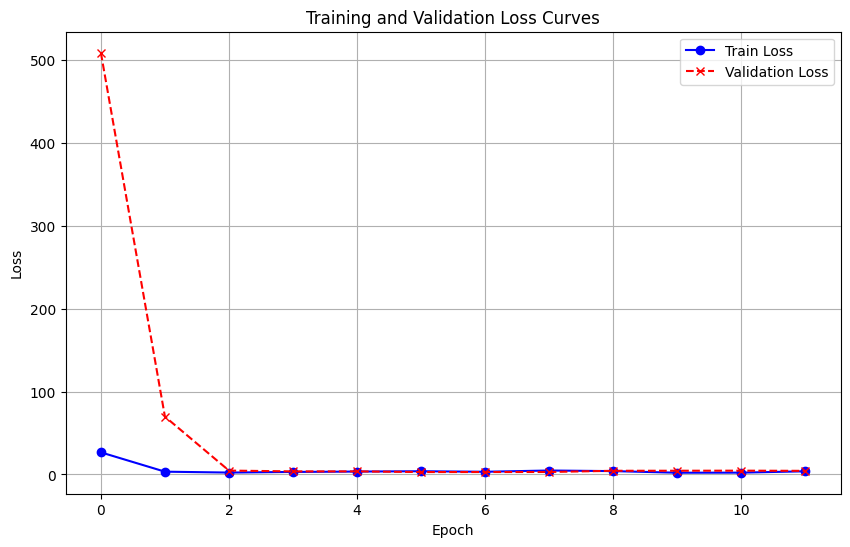

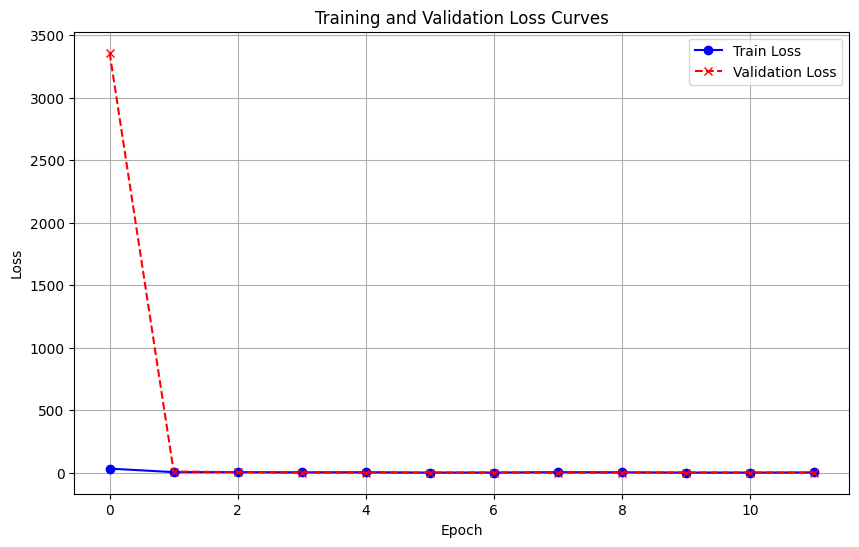

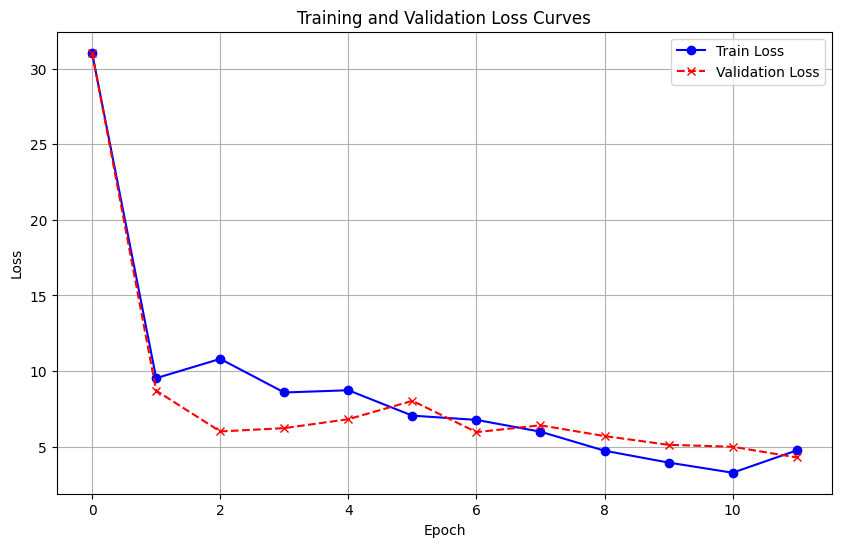

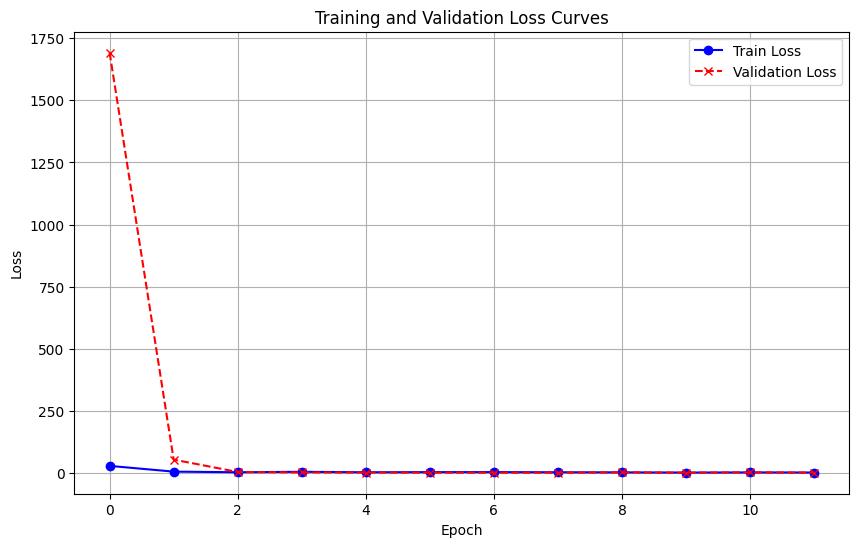

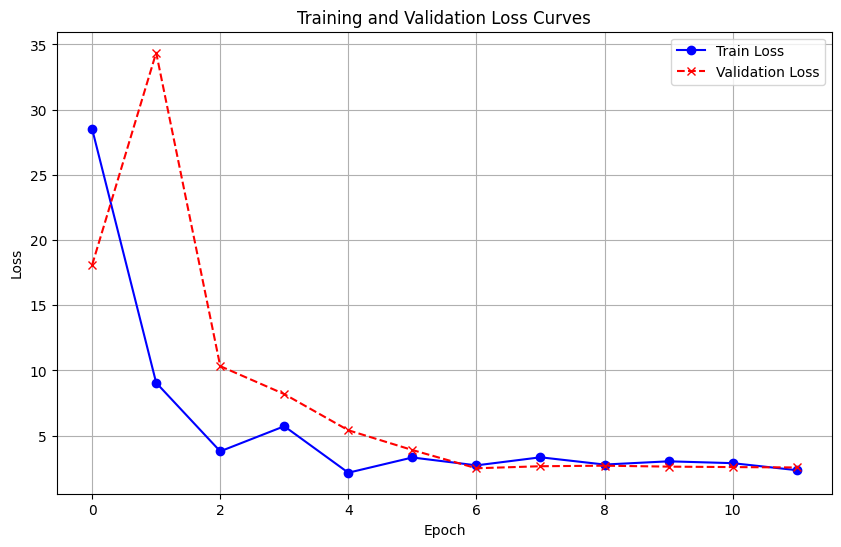

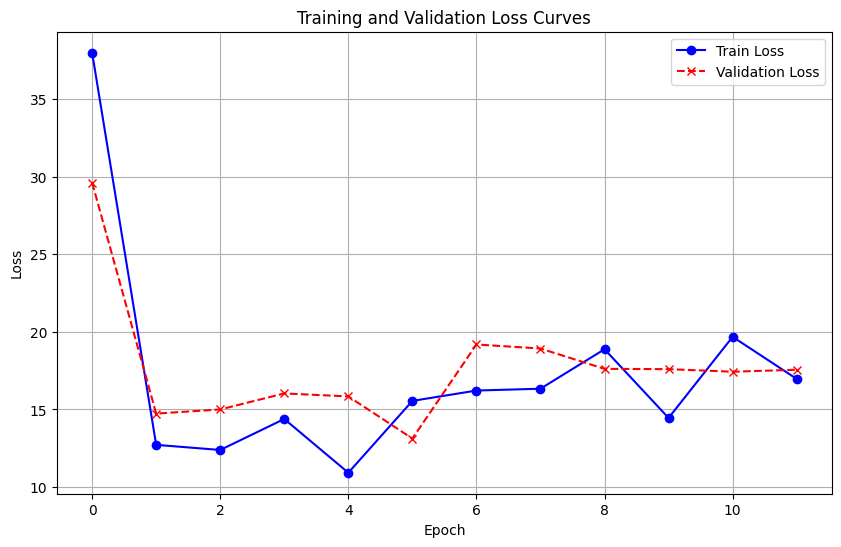

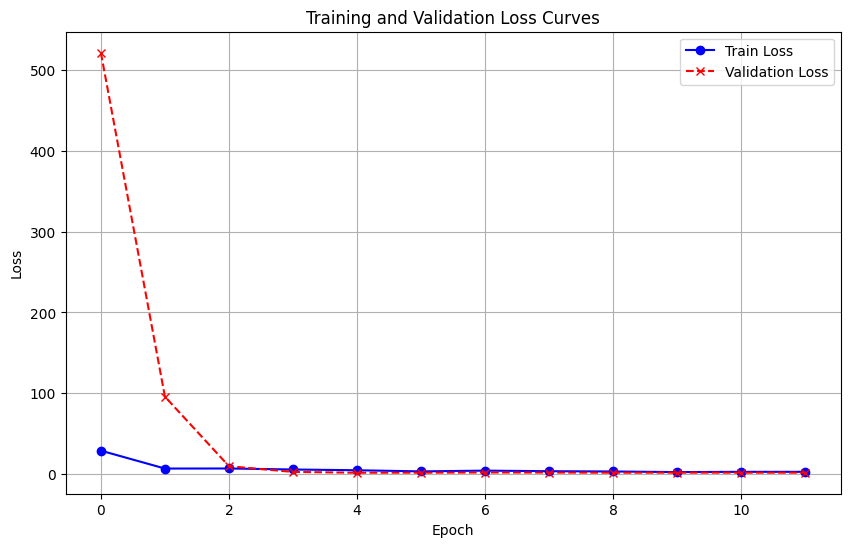

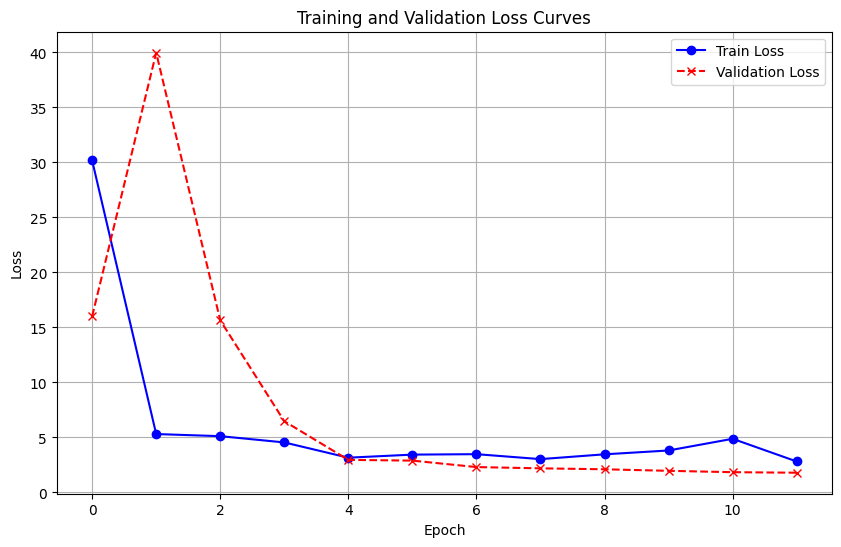

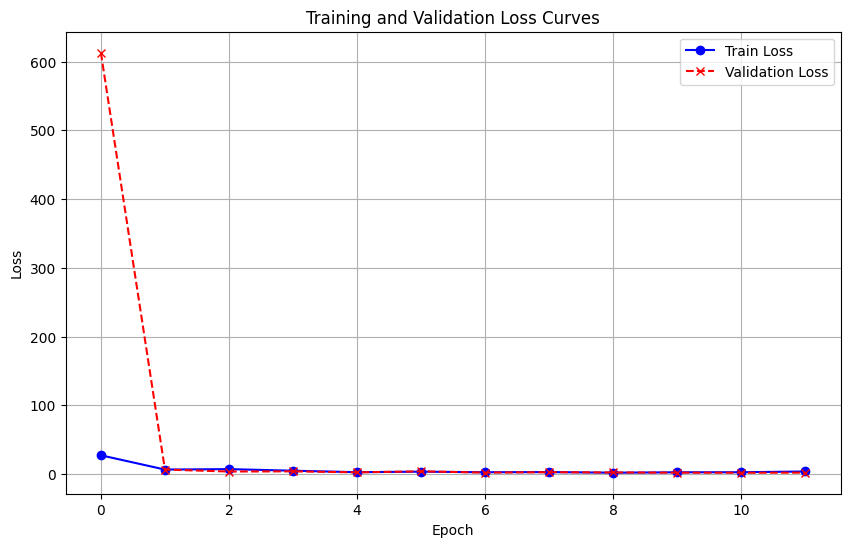

In [21]:
import os
import sys
from contextlib import redirect_stdout
MSEs=[]
MAEs=[]
R2s=[]

for i in range(0,9):
  data1, data2 = train_test_split(combined_df, test_size=0.3)
  train_data, test_data = data1, data2
  print("Training...")
  # Train the model
  input_size = train_data.shape[1] - 1  # Number of features
  model = train_model(train_data, input_size)

  # Evaluate the model
  print("Testing...")
  #test_mse, test_mae, test_r2 =predict(model, test_data)
  test_mse, test_mae, test_r2 =predict(model, test_df)
  MSEs.append(test_mse)
  MAEs.append(test_mae)
  R2s.append(test_r2)

MSEs=np.array(MSEs)
MAEs=np.array(MAEs)
R2s=np.array(R2s)

print(f"MSE={np.mean(MSEs)},var[MSE]={np.var(MSEs)}")
print(f"MAE={np.mean(MAEs)},var[MAE]={np.var(MAEs)}")
print(f"R2s={np.mean(R2s)},var[R2s]={np.var(R2s)}")



In [ ]:
# Evaluate the model
print("Testing...")
predict(model, test_data)

print("Testing")